In [1]:
import numpy as np

Nx = 128
Ny = 16

p = np.arange(128*16)

def compute_block_indices(host_idx, host_size):
    host_idx = np.array(host_idx)

    sub_size = host_size / 2
    n_host_x = Nx // host_size
    n_host_y = Ny // host_size
    n_sub_x = Nx // sub_size
    n_sub_y = Ny // sub_size
    
    sub_block_indices = np.array([])

    for idx in host_idx:
        host_index_x = idx % n_host_x
        host_index_y = idx // n_host_x

        sub_block_indices_idx = [
            host_index_y * n_sub_x * 2 + host_index_x * 2,
            host_index_y * n_sub_x * 2 + host_index_x * 2 + 1,
            (host_index_y * 2 + 1) * n_sub_x + host_index_x * 2,
            (host_index_y * 2 + 1) * n_sub_x + + host_index_x * 2 + 1,
        ]
        sub_block_indices_idx = np.array([int(i) for i in sub_block_indices_idx])
        sub_block_indices = np.concatenate((sub_block_indices, sub_block_indices_idx))

    particle_idx = []

    for i in sub_block_indices:
        sub_index_x = i % n_sub_x
        sub_index_y = i // n_sub_x

        left_index = sub_index_x * sub_size + sub_index_y * sub_size * Nx

        particle_idx.append(int(left_index))

    return sub_block_indices, np.array(particle_idx)
host = [0, 64]
print(compute_block_indices(host, 2))
# Output: [0, 1, 32, 33, 64, 65, 96, 97]

(array([  0.,   1., 128., 129., 256., 257., 384., 385.]), array([  0,   1, 128, 129, 256, 257, 384, 385]))


In [1]:
import numpy as np

Nx = 128
Ny = 16

p = np.arange(128*16)

def compute_indices(host, local, host_size):
    host = np.array(host)
    local = np.array(local)

    assert len(local) <= 4 * len(host)
    assert max(local) <= 4 * len(host)

    sub_size = host_size / 2
    n_host_x = Nx // host_size
    n_host_y = Ny // host_size
    n_sub_x = Nx // sub_size
    n_sub_y = Ny // sub_size
    
    sub_indices = []

    
    for i in local:
        host_index = host[i // 4]
        host_index_x = host_index % n_host_x
        host_index_y = host_index // n_host_x

        host_sub_indices = [
            host_index_y * n_sub_x * 2 + host_index_x * 2,
            host_index_y * n_sub_x * 2 + host_index_x * 2 + 1,
            (host_index_y * 2 + 1) * n_sub_x + host_index_x * 2,
            (host_index_y * 2 + 1) * n_sub_x + + host_index_x * 2 + 1,
        ]
        sub_index = int(host_sub_indices[i % 4])
        sub_indices.append(sub_index)

    particle_idx = []

    for i in sub_indices:
        sub_index_x = i % n_sub_x
        sub_index_y = i // n_sub_x

        left_index = sub_index_x * sub_size + sub_index_y * sub_size * Nx

        particle_idx.append(int(left_index))

    return particle_idx
host = [0, 16, 17]
local = [0,1,2,3,4,5,6,7,8,9,10,11]
print(compute_indices(host, local, 8))
# Output: [0, 1, 32, 33, 64, 65, 96, 97]

[0, 4, 512, 516, 1024, 1028, 1536, 1540, 1032, 1036, 1544, 1548]


In [216]:
with open(name) as json_file:
    result = json.load(json_file)['results'][-2]

np.unique(result)
import taichi as ti

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)
sub_block_values = ti.field(dtype=real, shape=(2, 10), needs_grad=True)
numpyarr = np.arange(20).reshape((2,10))
sub_block_values.from_numpy(numpyarr)
sum = 0
for i in range(2):
    for j in range(10):
        sum += sub_block_values[i, j] == numpyarr[i, j]
numpyarr

[Taichi] Starting on arch=cuda


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

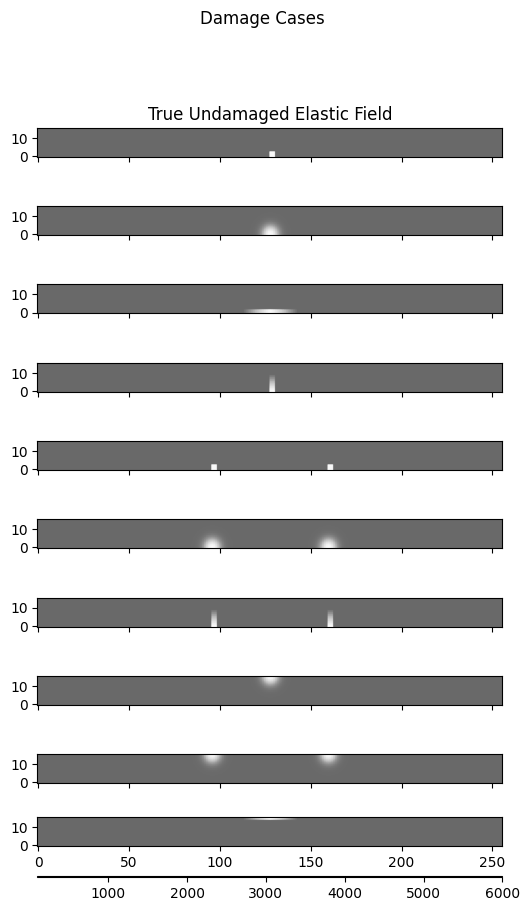

In [3]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


filenames_1e4 = []
for name in filenames:
    if '10000' in name:
        filenames_1e4.append(name)



E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 256
Ny = 16
n_particles = Nx * Ny

E_d = np.zeros(n_particles) + 4000
E_g = np.zeros(n_particles) + 4000
E_h = np.zeros(n_particles) + 4000
E_v = np.zeros(n_particles) + 4000
E_d_m = np.zeros(n_particles) + 4000
E_g_m = np.zeros(n_particles) + 4000
E_v_m = np.zeros(n_particles) + 4000
E_gt = np.zeros(n_particles) + 4000
E_gt_m = np.zeros(n_particles) + 4000
E_ht = np.zeros(n_particles) + 4000

def discrete_damage(left, width, height):
    idx = np.array([])
    for row in np.arange(height):
        idx = np.concatenate((idx, np.arange(left+Nx*row, left+width+Nx*row)))
    
    return [int(i) for i in idx]

def gradient_damage(E, start, width, half_length, horizontal=True, E_start=400, E_stop=4000):
    interp = np.interp(np.arange(half_length), [0, half_length-1], [E_start, E_stop])
    if horizontal:
        for row in np.arange(width):
            E[np.arange(start+Nx*row, start+half_length+Nx*row)] = interp
            E[np.arange(start+Nx*row, start-half_length+Nx*row, -1)] = interp
    else:
        for col in np.arange(width):
            E[np.arange(start+col, start+col+half_length*Nx, Nx)] = interp

def gaussian_damage(E, center, start=3600, cov=[[10, 0], [0, 10]]):
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
    coords = np.column_stack([x.ravel(), y.ravel()])

    dmg = multivariate_normal.pdf(coords, mean=center, cov=cov)
    dmg = dmg.reshape(E.shape)
    
    dmg = dmg / dmg.max() * start
    E = E - dmg
    return E

E_d_damage_idx = discrete_damage(128, 3, 3)
E_d[E_d_damage_idx] = np.repeat(400, len(E_d_damage_idx))

E_d_m_damage_idx = np.concatenate((discrete_damage(96, 3, 3), discrete_damage(160, 3, 3)))
E_d_m[E_d_m_damage_idx] = np.repeat(400, len(E_d_m_damage_idx))

gradient_damage(E_h, 128, 2, 16)
gradient_damage(E_ht, n_particles-128-Nx, 2, 16)

gradient_damage(E_v, 128, 3, 10, horizontal=False)
gradient_damage(E_v_m, 96, 3, 10, horizontal=False)
gradient_damage(E_v_m, 160, 3, 10, horizontal=False)

E_g = gaussian_damage(E_g, [128, 0])
E_g_m = gaussian_damage(E_g_m, [96, 0])
E_g_m = gaussian_damage(E_g_m, [160, 0])
E_gt = gaussian_damage(E_gt, [128, 15])
E_gt_m = gaussian_damage(E_gt_m, [96, 15])
E_gt_m = gaussian_damage(E_gt_m, [160, 15])

E_d = einops.rearrange(E_d, "(y x) -> x y", y=Ny).transpose()
E_g = einops.rearrange(E_g, "(y x) -> x y", y=Ny).transpose()
E_h = einops.rearrange(E_h, "(y x) -> x y", y=Ny).transpose()
E_v = einops.rearrange(E_v, "(y x) -> x y", y=Ny).transpose()
E_d_m = einops.rearrange(E_d_m, "(y x) -> x y", y=Ny).transpose()
E_g_m = einops.rearrange(E_g_m, "(y x) -> x y", y=Ny).transpose()
E_v_m = einops.rearrange(E_v_m, "(y x) -> x y", y=Ny).transpose()
E_gt = einops.rearrange(E_gt, "(y x) -> x y", y=Ny).transpose()
E_gt_m = einops.rearrange(E_gt_m, "(y x) -> x y", y=Ny).transpose()
E_ht = einops.rearrange(E_ht, "(y x) -> x y", y=Ny).transpose()

fig, axs = plt.subplots(10,1, sharex=True, sharey=True, figsize=(6,10))


fig.suptitle('Damage Cases')

axs[0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
axs[0].set_title('True Undamaged Elastic Field')

axs[1].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[1].set_title('True Damaged Elastic Field')

axs[2].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[2].set_title('True Damaged Elastic Field')

axs[3].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[3].set_title('True Damaged Elastic Field')

axs[4].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[4].set_title('True Damaged Elastic Field')

axs[5].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[5].set_title('True Damaged Elastic Field')

axs[6].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
# axs[6].set_title('True Damaged Elastic Field')

axs[7].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)

axs[8].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)


im = axs[9].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
divider = make_axes_locatable(axs[9])
cax = divider.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im, cax=cax, orientation='horizontal')

# im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 0].set_title('Estimated Undamaged Field, Discrete Surface Observability')
# divider1 = make_axes_locatable(axs[2, 0])
# cax1 = divider1.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im1, cax=cax1, orientation='horizontal')

# im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 1].set_title('Estimated Damaged Field, Discrete Surface Observability')
# divider2 = make_axes_locatable(axs[2, 1])
# cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()
    

    


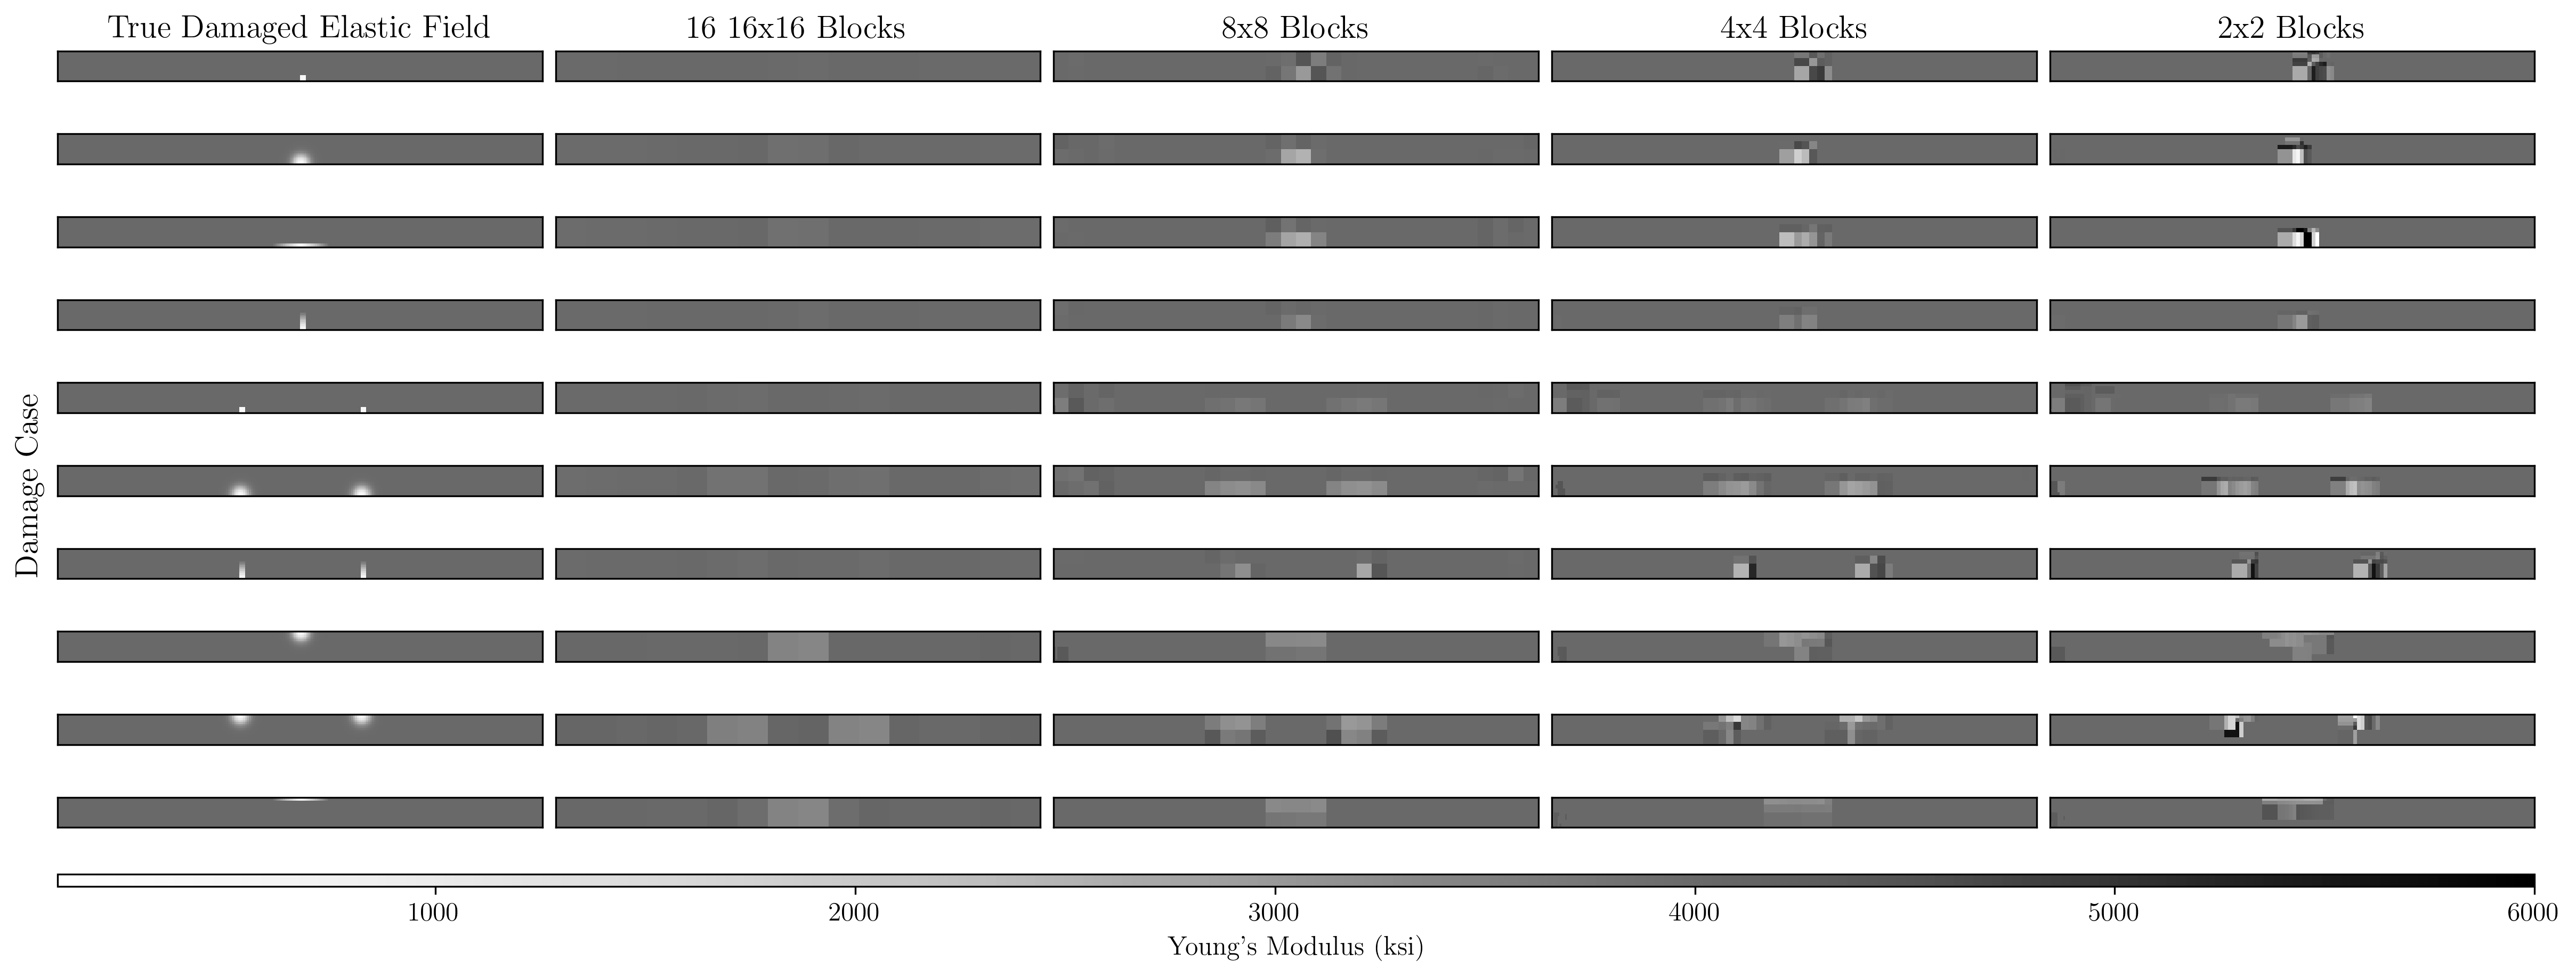

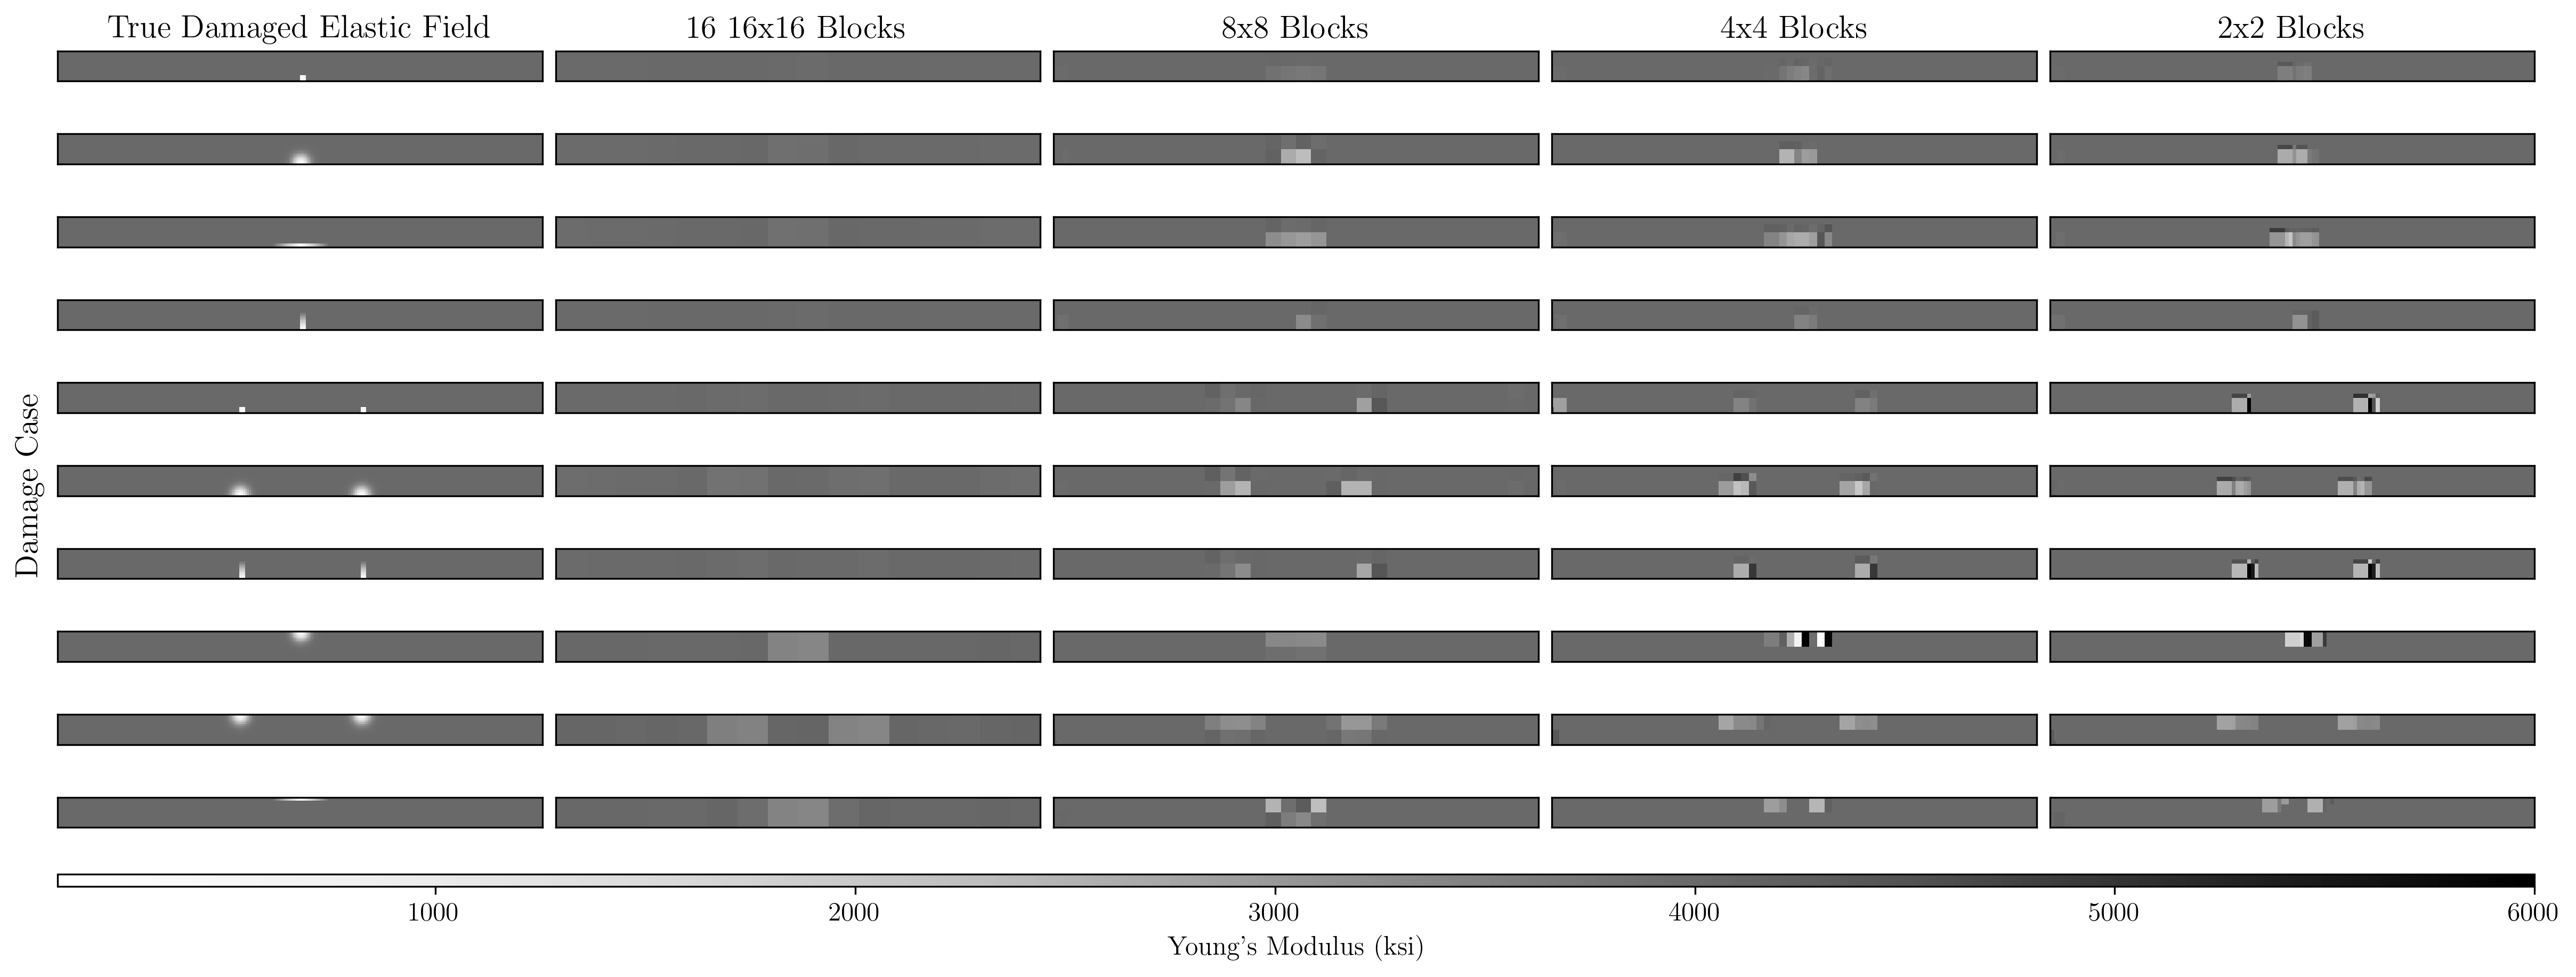

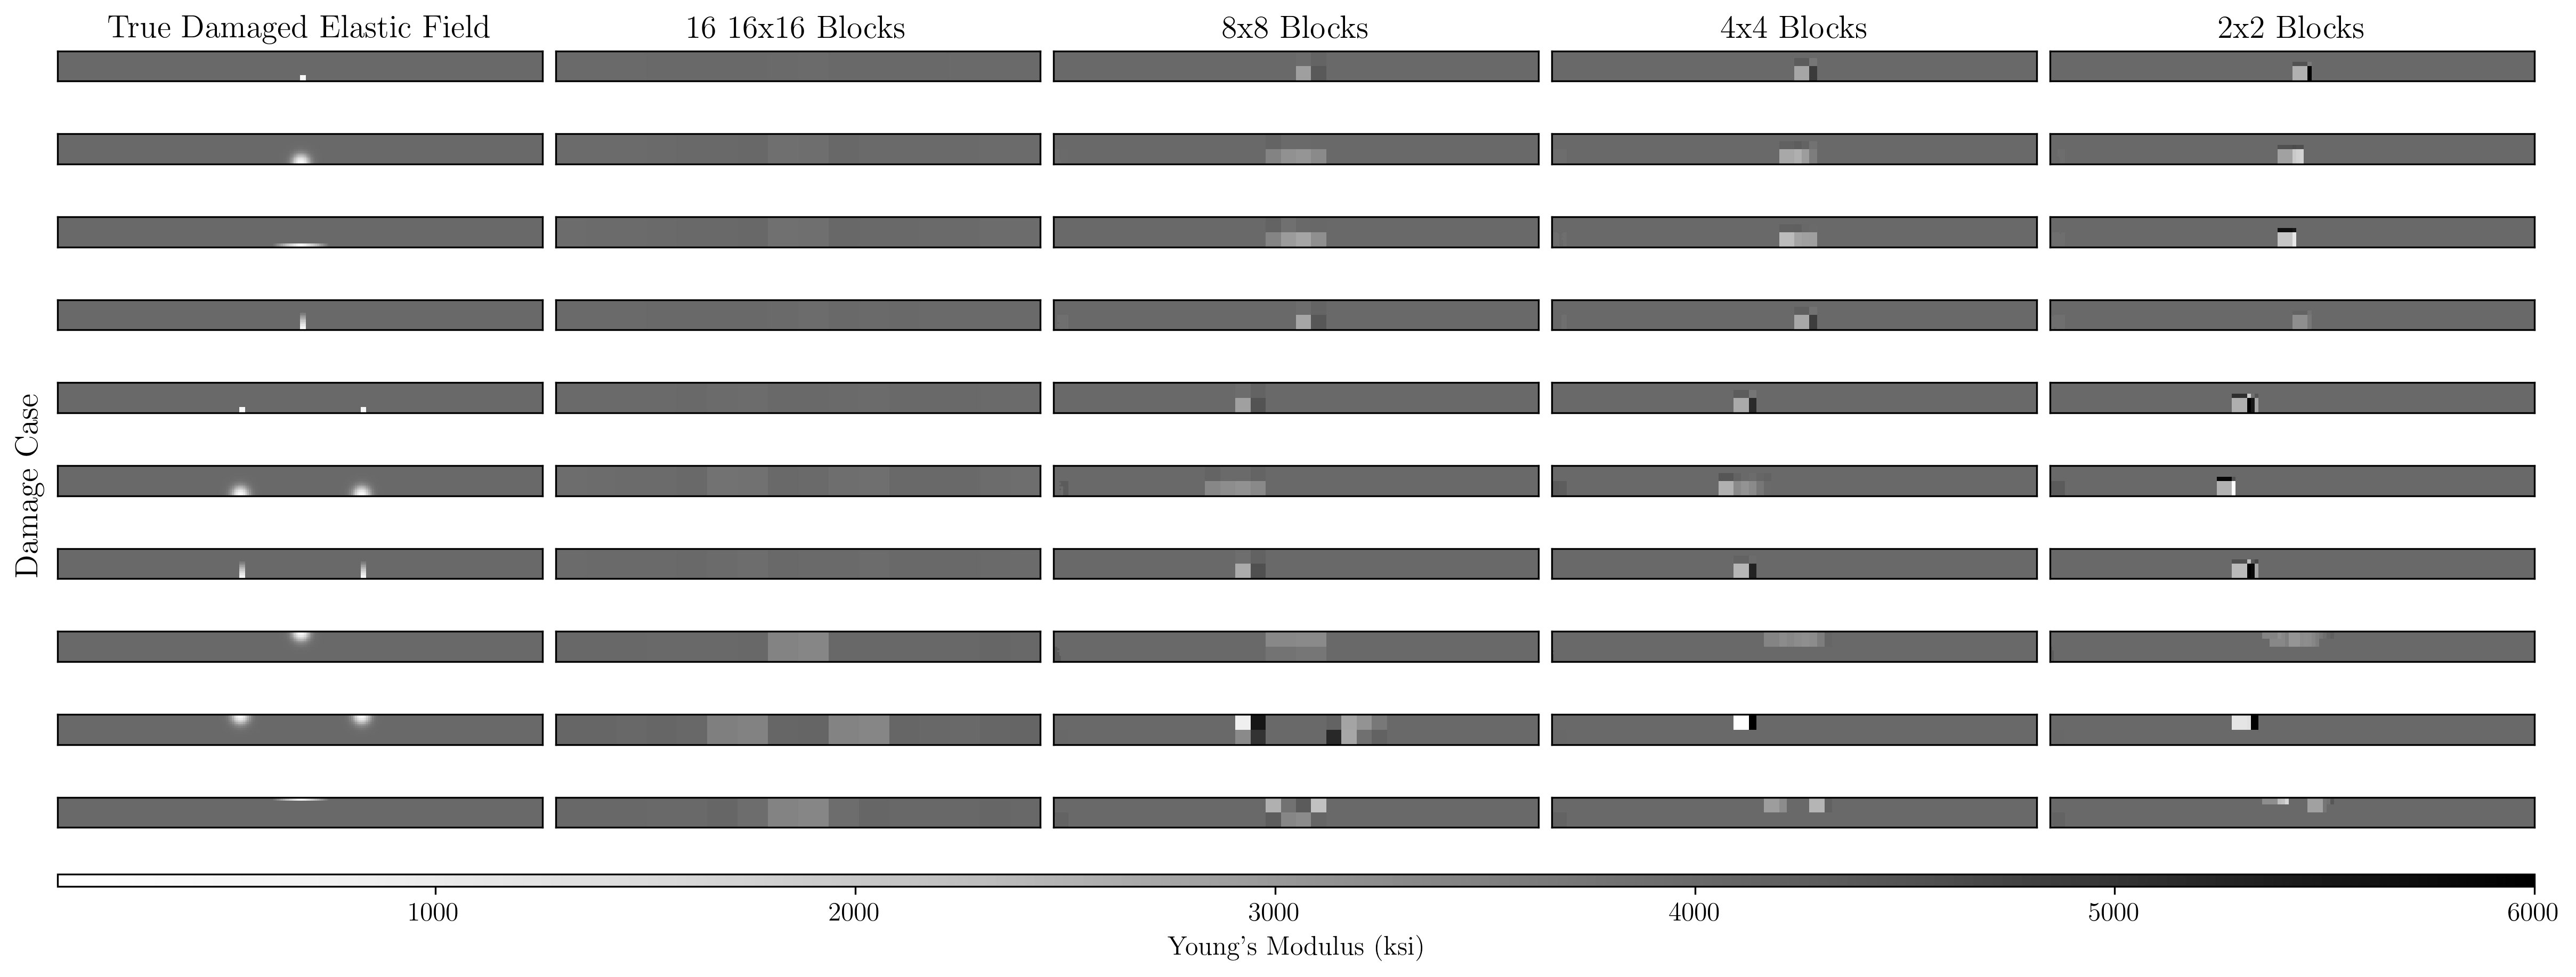

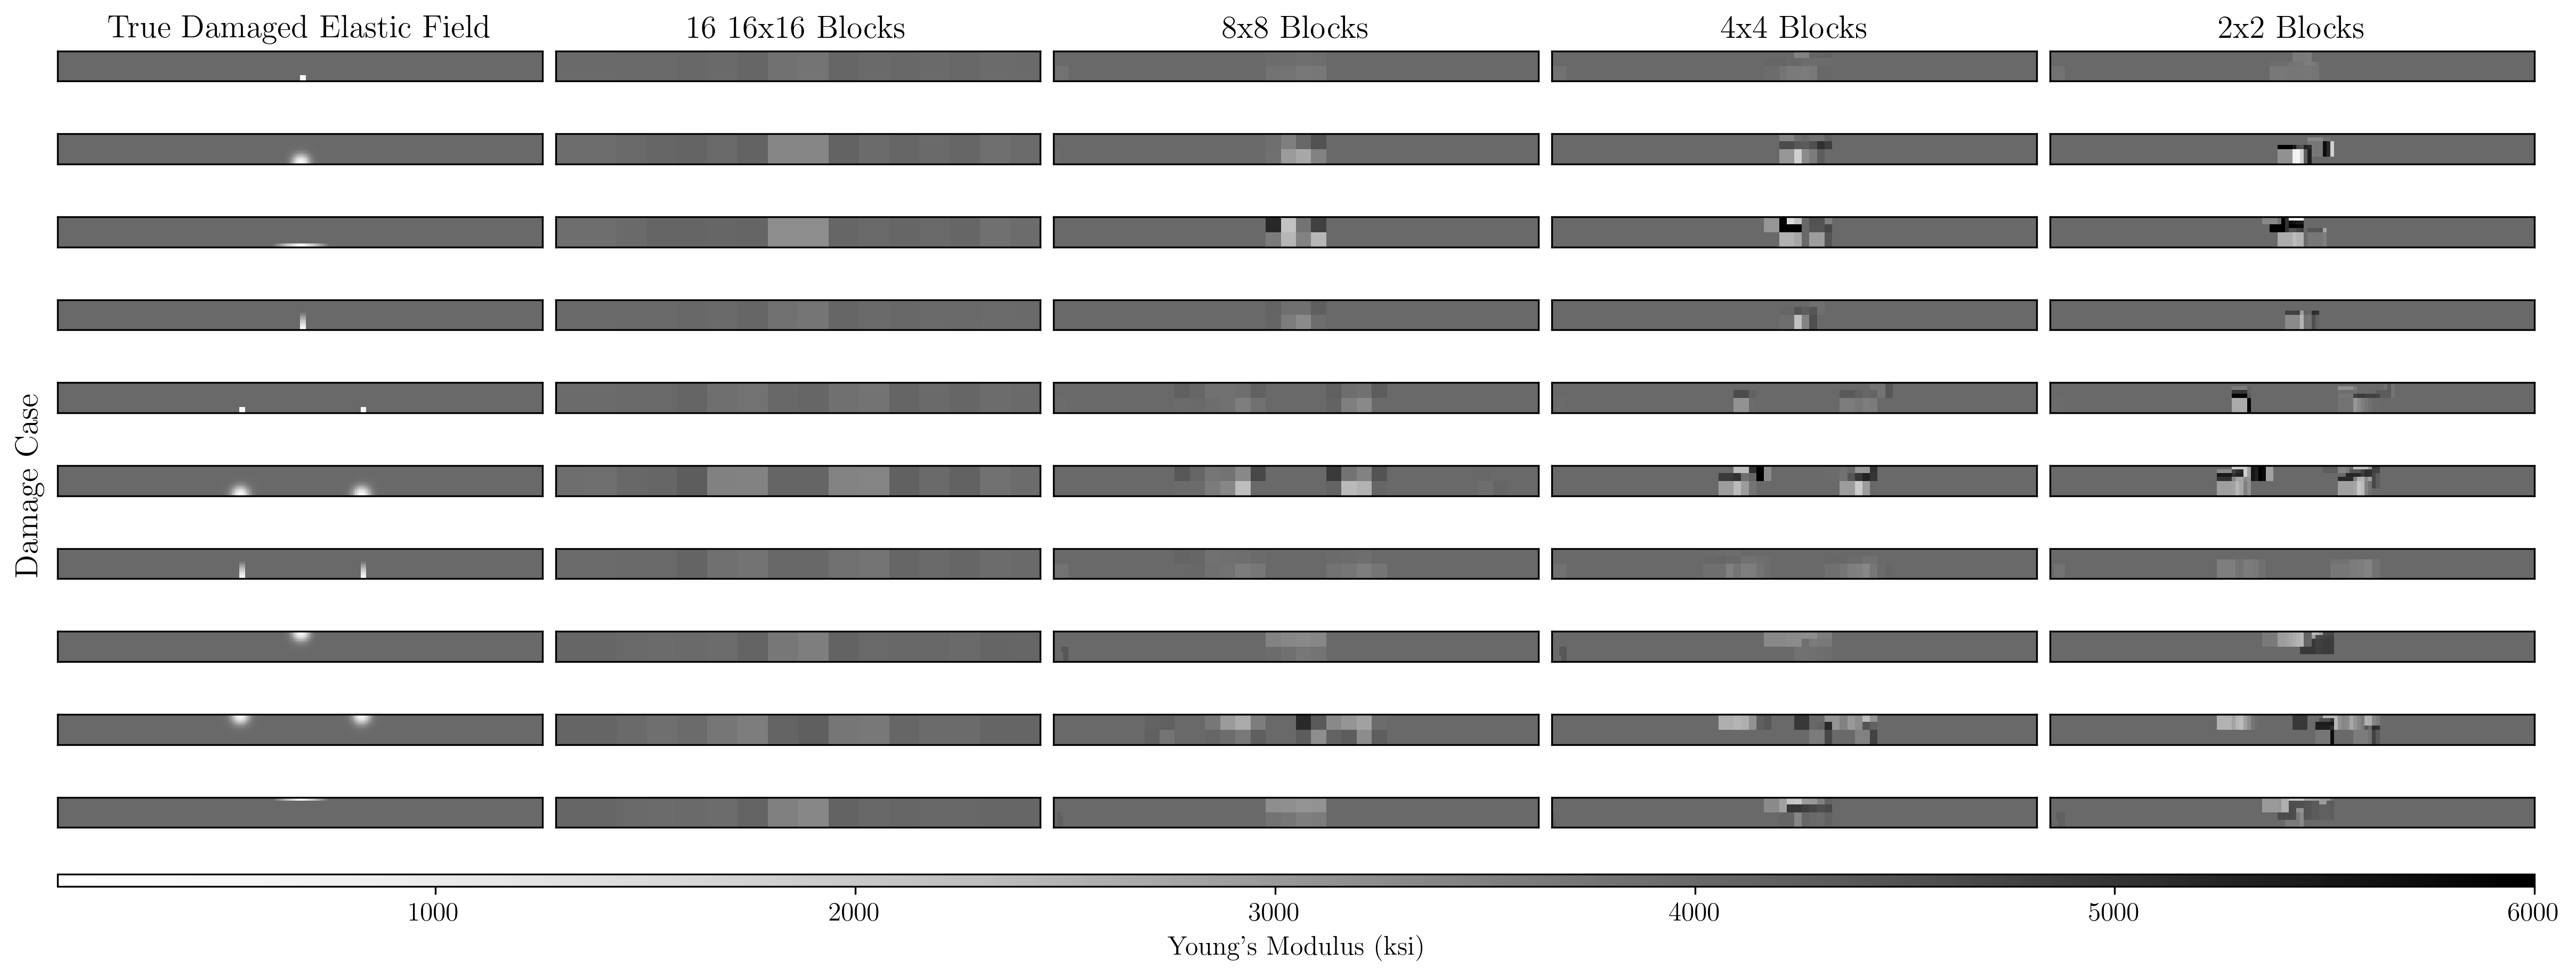

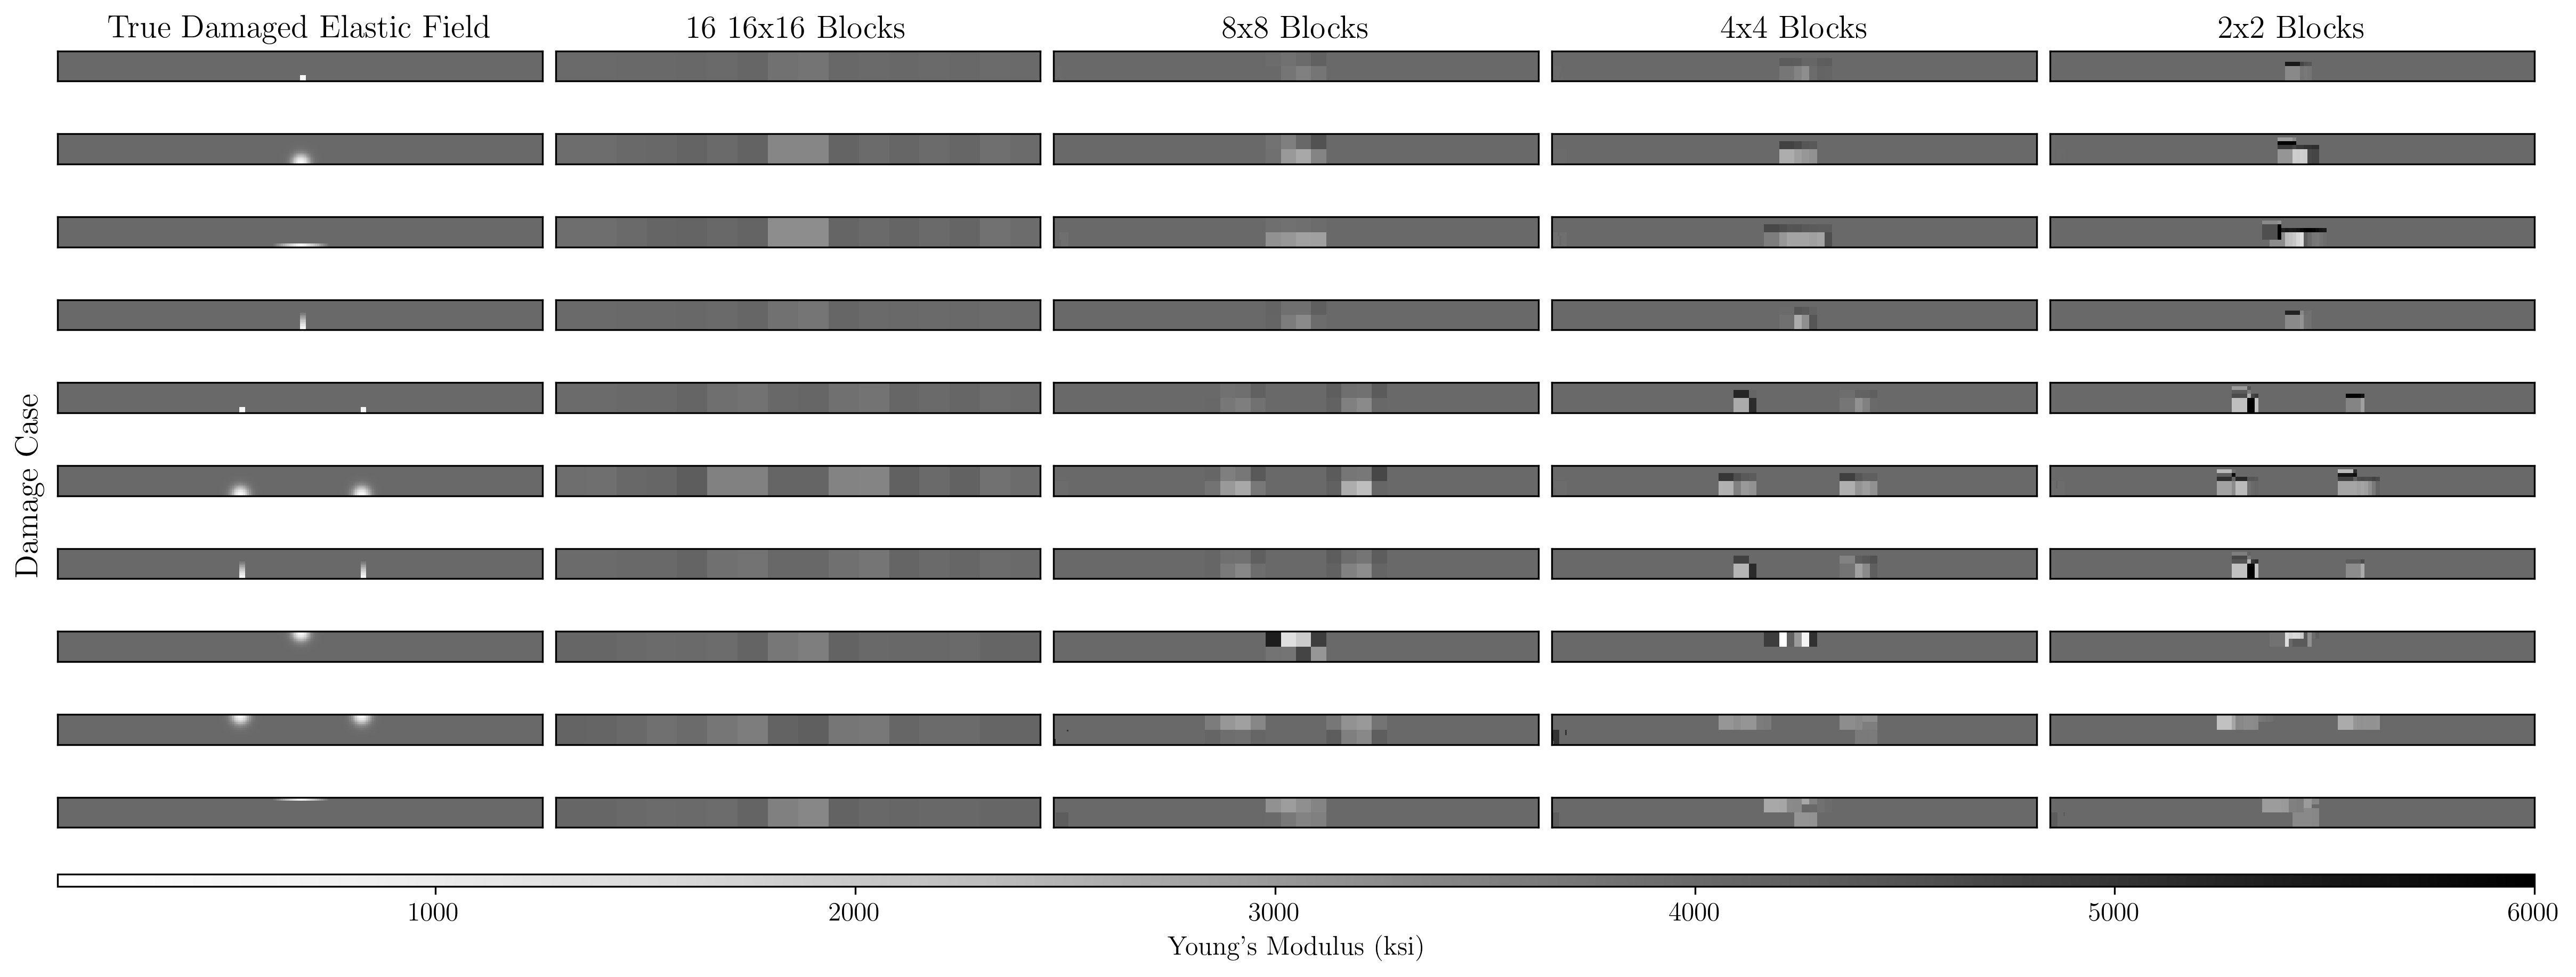

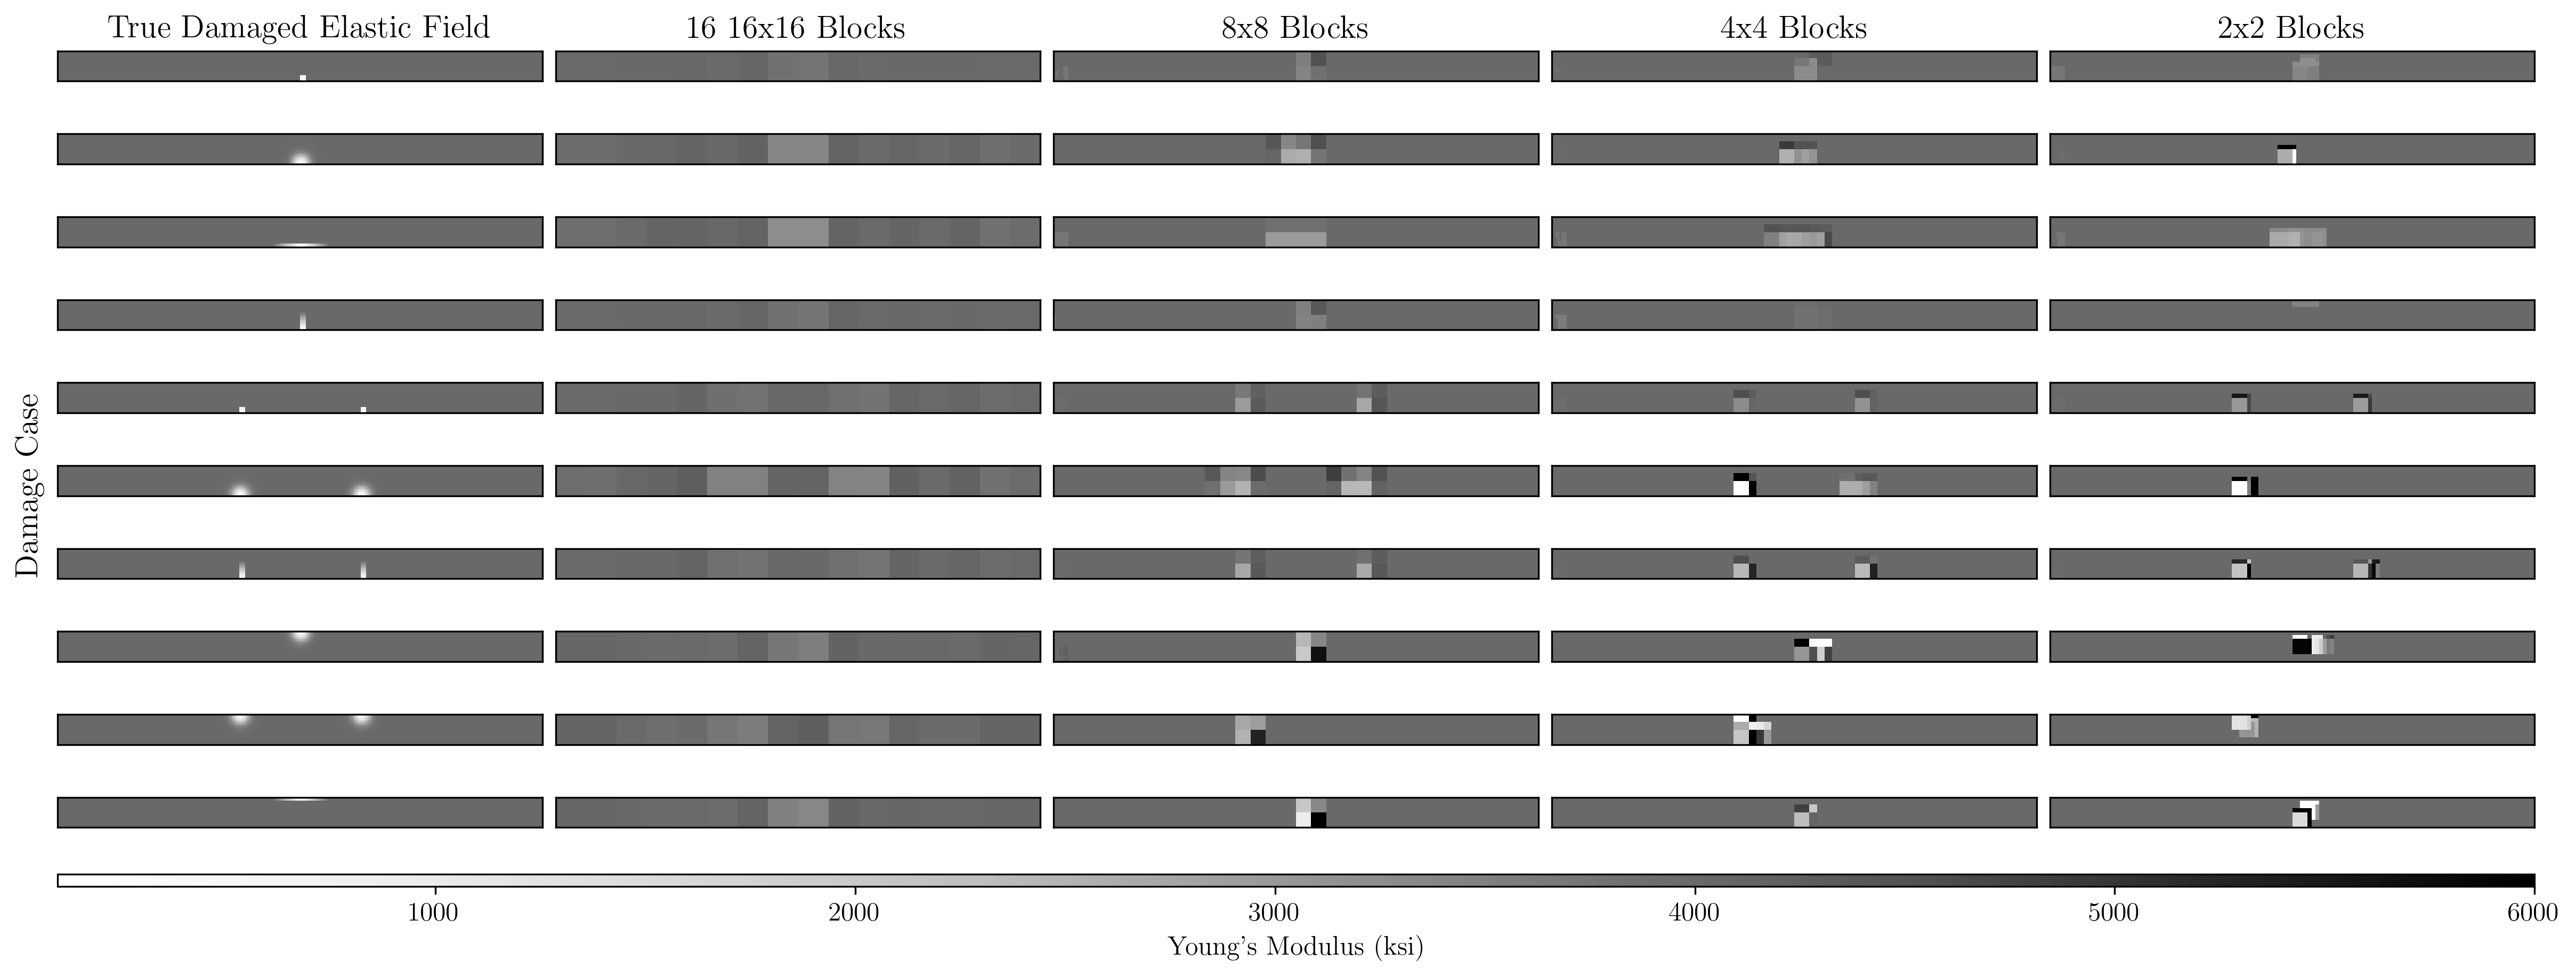

In [89]:
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')
import matplotlib.pyplot as plt
import matplotlib, os
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)



obs_choices = ["full", "sensor"]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
deviation_threshold_list = [0.3, 0.5, 0.8]

obs = 'full'
threshold = 0.5

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 256
Ny = 16
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for obs in obs_choices:
    for threshold in deviation_threshold_list:
        fig, axs = plt.subplots(10,5, sharex=True, sharey=True, figsize=(16,6), layout='constrained')


        # fig.suptitle(f'{obs} observability, {threshold} damage threshold')

        axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[0, 0].set_title('True Damaged Elastic Field')
        axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        # for i in range(10):
        #     axs[i, 0].set_ylabel(str(i))

        for k, case in enumerate(cases):
            filename = [
                f"r_c_{case}_{obs}_{int(threshold*10)}.json",
            ]
            for z in range(4):
                with open(filename[0]) as json_file:
                    result = json.load(json_file)['results'][z]   
                E = np.zeros(n_particles)
                for i in range(Nx):
                    for j in range(Ny):
                        E[j*Nx+i] = result[i + j * Nx]
                E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
                
                axs[k, z + 1].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
        axs[0, 1].set_title('16 16x16 Blocks')
        axs[0, 2].set_title('8x8 Blocks')
        axs[0, 3].set_title('4x4 Blocks')
        axs[0, 4].set_title('2x2 Blocks')

        for i in range(10):
            for j in range(5):
                axs[i, j].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,
                    labelleft=False,
                    labelbottom=False)
        fig.supylabel('Damage Case')
        fig.colorbar(im, 
                     ax=axs, 
                     orientation = 'horizontal', 
                     label='Young\'s Modulus (ksi)', 
                     aspect=200)
        plt.show()

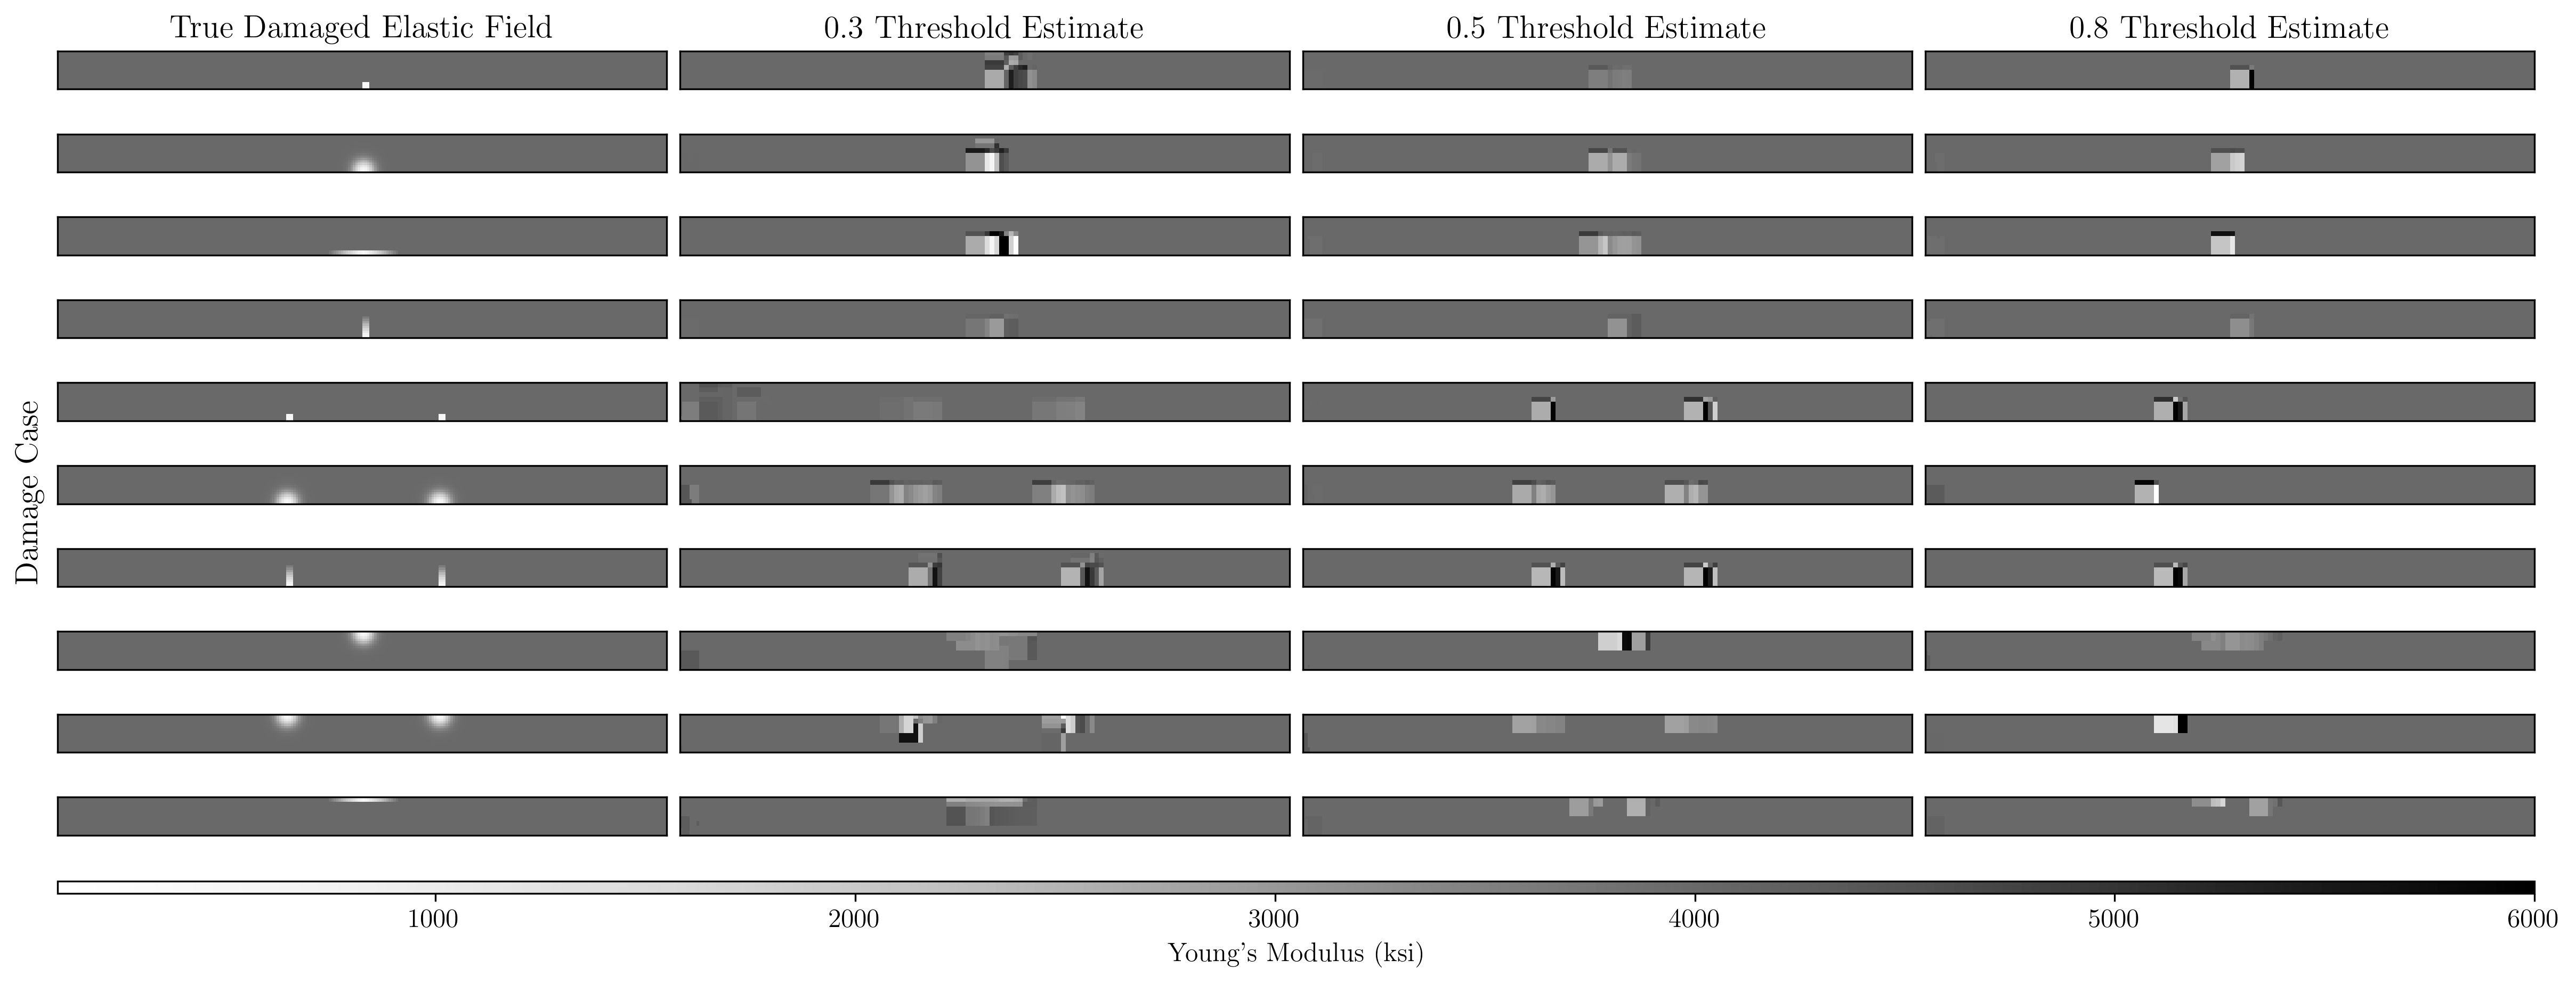

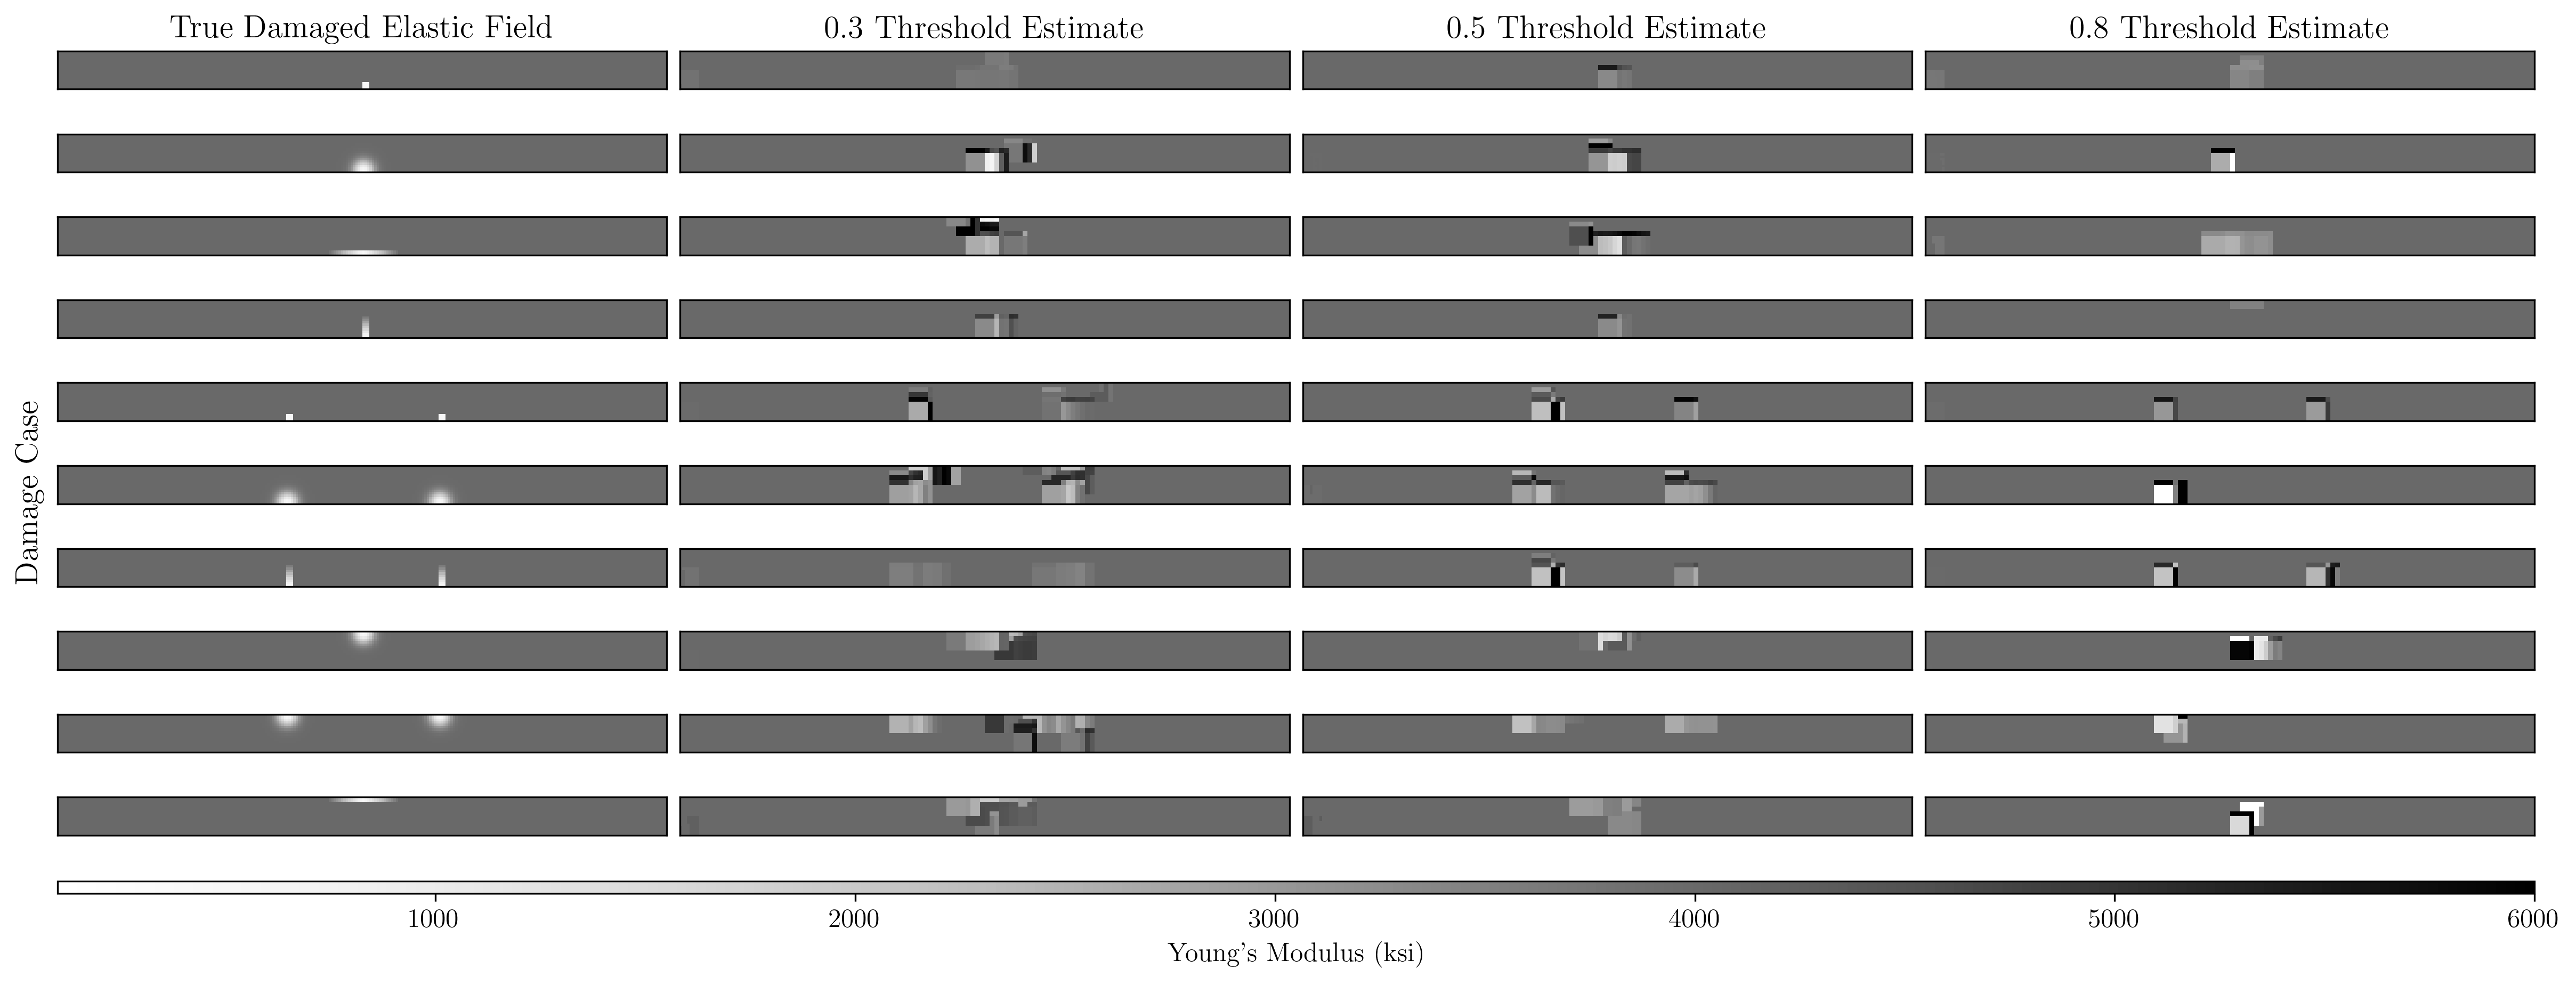

In [90]:
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')
import matplotlib.pyplot as plt
import matplotlib, os
matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 12}
matplotlib.rc('font', **font)



obs_choices = ["full", "sensor"]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
deviation_threshold_list = [0.3, 0.5, 0.8]

obs = 'full'
threshold = 0.5

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 256
Ny = 16
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for obs in obs_choices:
    
    fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6), layout='constrained')


    # fig.suptitle(f'{obs} observability, 2x2 granularity')
    
    axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[0, 0].set_title('True Damaged Elastic Field')
    axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    # for i in range(10):
    #     axs[i, 0].set_ylabel(str(i))
    for l, threshold in enumerate(deviation_threshold_list):
        for k, case in enumerate(cases):
            filename = [
                f"r_c_{case}_{obs}_{int(threshold*10)}.json",
            ]
            with open(filename[0]) as json_file:
                result = json.load(json_file)['results'][3]   
            E = np.zeros(n_particles)
            for i in range(Nx):
                for j in range(Ny):
                    E[j*Nx+i] = result[i + j * Nx]
            E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
            
            axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=100, vmax = 6000)
    axs[0, 1].set_title('0.3 Threshold Estimate')
    axs[0, 2].set_title('0.5 Threshold Estimate')
    axs[0, 3].set_title('0.8 Threshold Estimate')

    for i in range(10):
            for j in range(4):
                axs[i, j].tick_params(
                    axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,
                    labelleft=False,
                    labelbottom=False)
    fig.supylabel('Damage Case')
    fig.colorbar(im, 
                    ax=axs, 
                    orientation = 'horizontal', 
                    label='Young\'s Modulus (ksi)', 
                    aspect=200)
    plt.show()

In [60]:
import itertools

obs_choices = ["full", "sensor"]
cases = ['d', 'dm', 'g', 'gm', 'h', 'v', 'vm', 'gt', 'gtm', 'ht']
deviation_threshold_list = [0.3, 0.5, 0.8,]

combinations = list(itertools.product(obs_choices, cases, deviation_threshold_list))


for obs, case, deviation in combinations:
    filename = [
        f"r_c_{case}_{obs}_{int(threshold*10)}.json",
    ]

    with open(filename[0]) as json_file:
        result = json.load(json_file)['results'][0]

    print(np.array(result).min())

3961.14501953125
3961.14501953125
3961.14501953125
3933.693115234375
3933.693115234375
3933.693115234375
3879.001708984375
3879.001708984375
3879.001708984375
3797.661376953125
3797.661376953125
3797.661376953125
3834.11279296875
3834.11279296875
3834.11279296875
3945.647216796875
3945.647216796875
3945.647216796875
3913.43359375
3913.43359375
3913.43359375
3373.637451171875
3373.637451171875
3373.637451171875
3376.9560546875
3376.9560546875
3376.9560546875
3386.4013671875
3386.4013671875
3386.4013671875
3758.809326171875
3758.809326171875
3758.809326171875
3771.3740234375
3771.3740234375
3771.3740234375
3389.687744140625
3389.687744140625
3389.687744140625
3407.790771484375
3407.790771484375
3407.790771484375
3225.894287109375
3225.894287109375
3225.894287109375
3735.97705078125
3735.97705078125
3735.97705078125
3742.917236328125
3742.917236328125
3742.917236328125
3536.650146484375
3536.650146484375
3536.650146484375
3570.486572265625
3570.486572265625
3570.486572265625
3370.94018554

In [ ]:
def compute_block_indices(host_idx, host_size):
    host_idx = np.array(host_idx)

    sub_size = host_size / 2
    n_host_x = Nx // host_size
    n_host_y = Ny // host_size
    n_sub_x = Nx // sub_size
    n_sub_y = Ny // sub_size
    
    sub_block_indices = np.array([])

    for idx in host_idx:
        host_index_x = idx % n_host_x
        host_index_y = idx // n_host_x

        sub_block_indices_idx = [
            host_index_y * n_sub_x * 2 + host_index_x * 2,
            host_index_y * n_sub_x * 2 + host_index_x * 2 + 1,
            (host_index_y * 2 + 1) * n_sub_x + host_index_x * 2,
            (host_index_y * 2 + 1) * n_sub_x + + host_index_x * 2 + 1,
        ]
        sub_block_indices_idx = np.array([int(i) for i in sub_block_indices_idx])
        sub_block_indices = np.concatenate((sub_block_indices, sub_block_indices_idx))

    particle_idx = []

    for i in sub_block_indices:
        sub_index_x = i % n_sub_x
        sub_index_y = i // n_sub_x

        left_index = sub_index_x * sub_size + sub_index_y * sub_size * Nx

        particle_idx.append(int(left_index))

    return sub_block_indices, np.array(particle_idx)
case = "d"
obs = "full"
threshold = 0.3
z = 0
filename = [
    f"r_c_{case}_{obs}_{int(threshold*10)}.json",
]

with open(filename[0]) as json_file:
    result = json.load(json_file)['results'][z]
arr = np.array([])

for i in result:
    if i not in arr:
        arr = np.append(arr, i)

result = arr
deviation = np.abs(np.array(result) - 4e3)
max_deviation = np.max(deviation)
exceed = np.where(deviation >= max_deviation * threshold)[0]
exceed_values = np.array(result)[exceed]

n_targets = len(exceed) * 4
n_sub_blocks = len(exceed) * 4
sub_block_x = 8
sub_block_y = 8
sub_block_index_np, sub_block_particle_index_np = compute_block_indices(exceed, 16)
sub_block_index_np
sub_block_particle_index_np = np.concatenate((
sub_block_particle_index_np, 
np.zeros(n_particles-len(sub_block_particle_index_np))
))
sub_block_particle_index_np

import taichi as ti
ti.init()
sub_block_particle_index = ti.field(dtype=int, shape=(n_particles))
sub_block_particle_index.from_numpy(sub_block_particle_index_np)
arr = np.array([])
for i in range(n_targets):
        for j in range(sub_block_x):
            for k in range(sub_block_y):
                arr = np.append(arr, sub_block_particle_index[i] + j + k * 256)

arr.min()

[Taichi] Starting on arch=x64


0.0

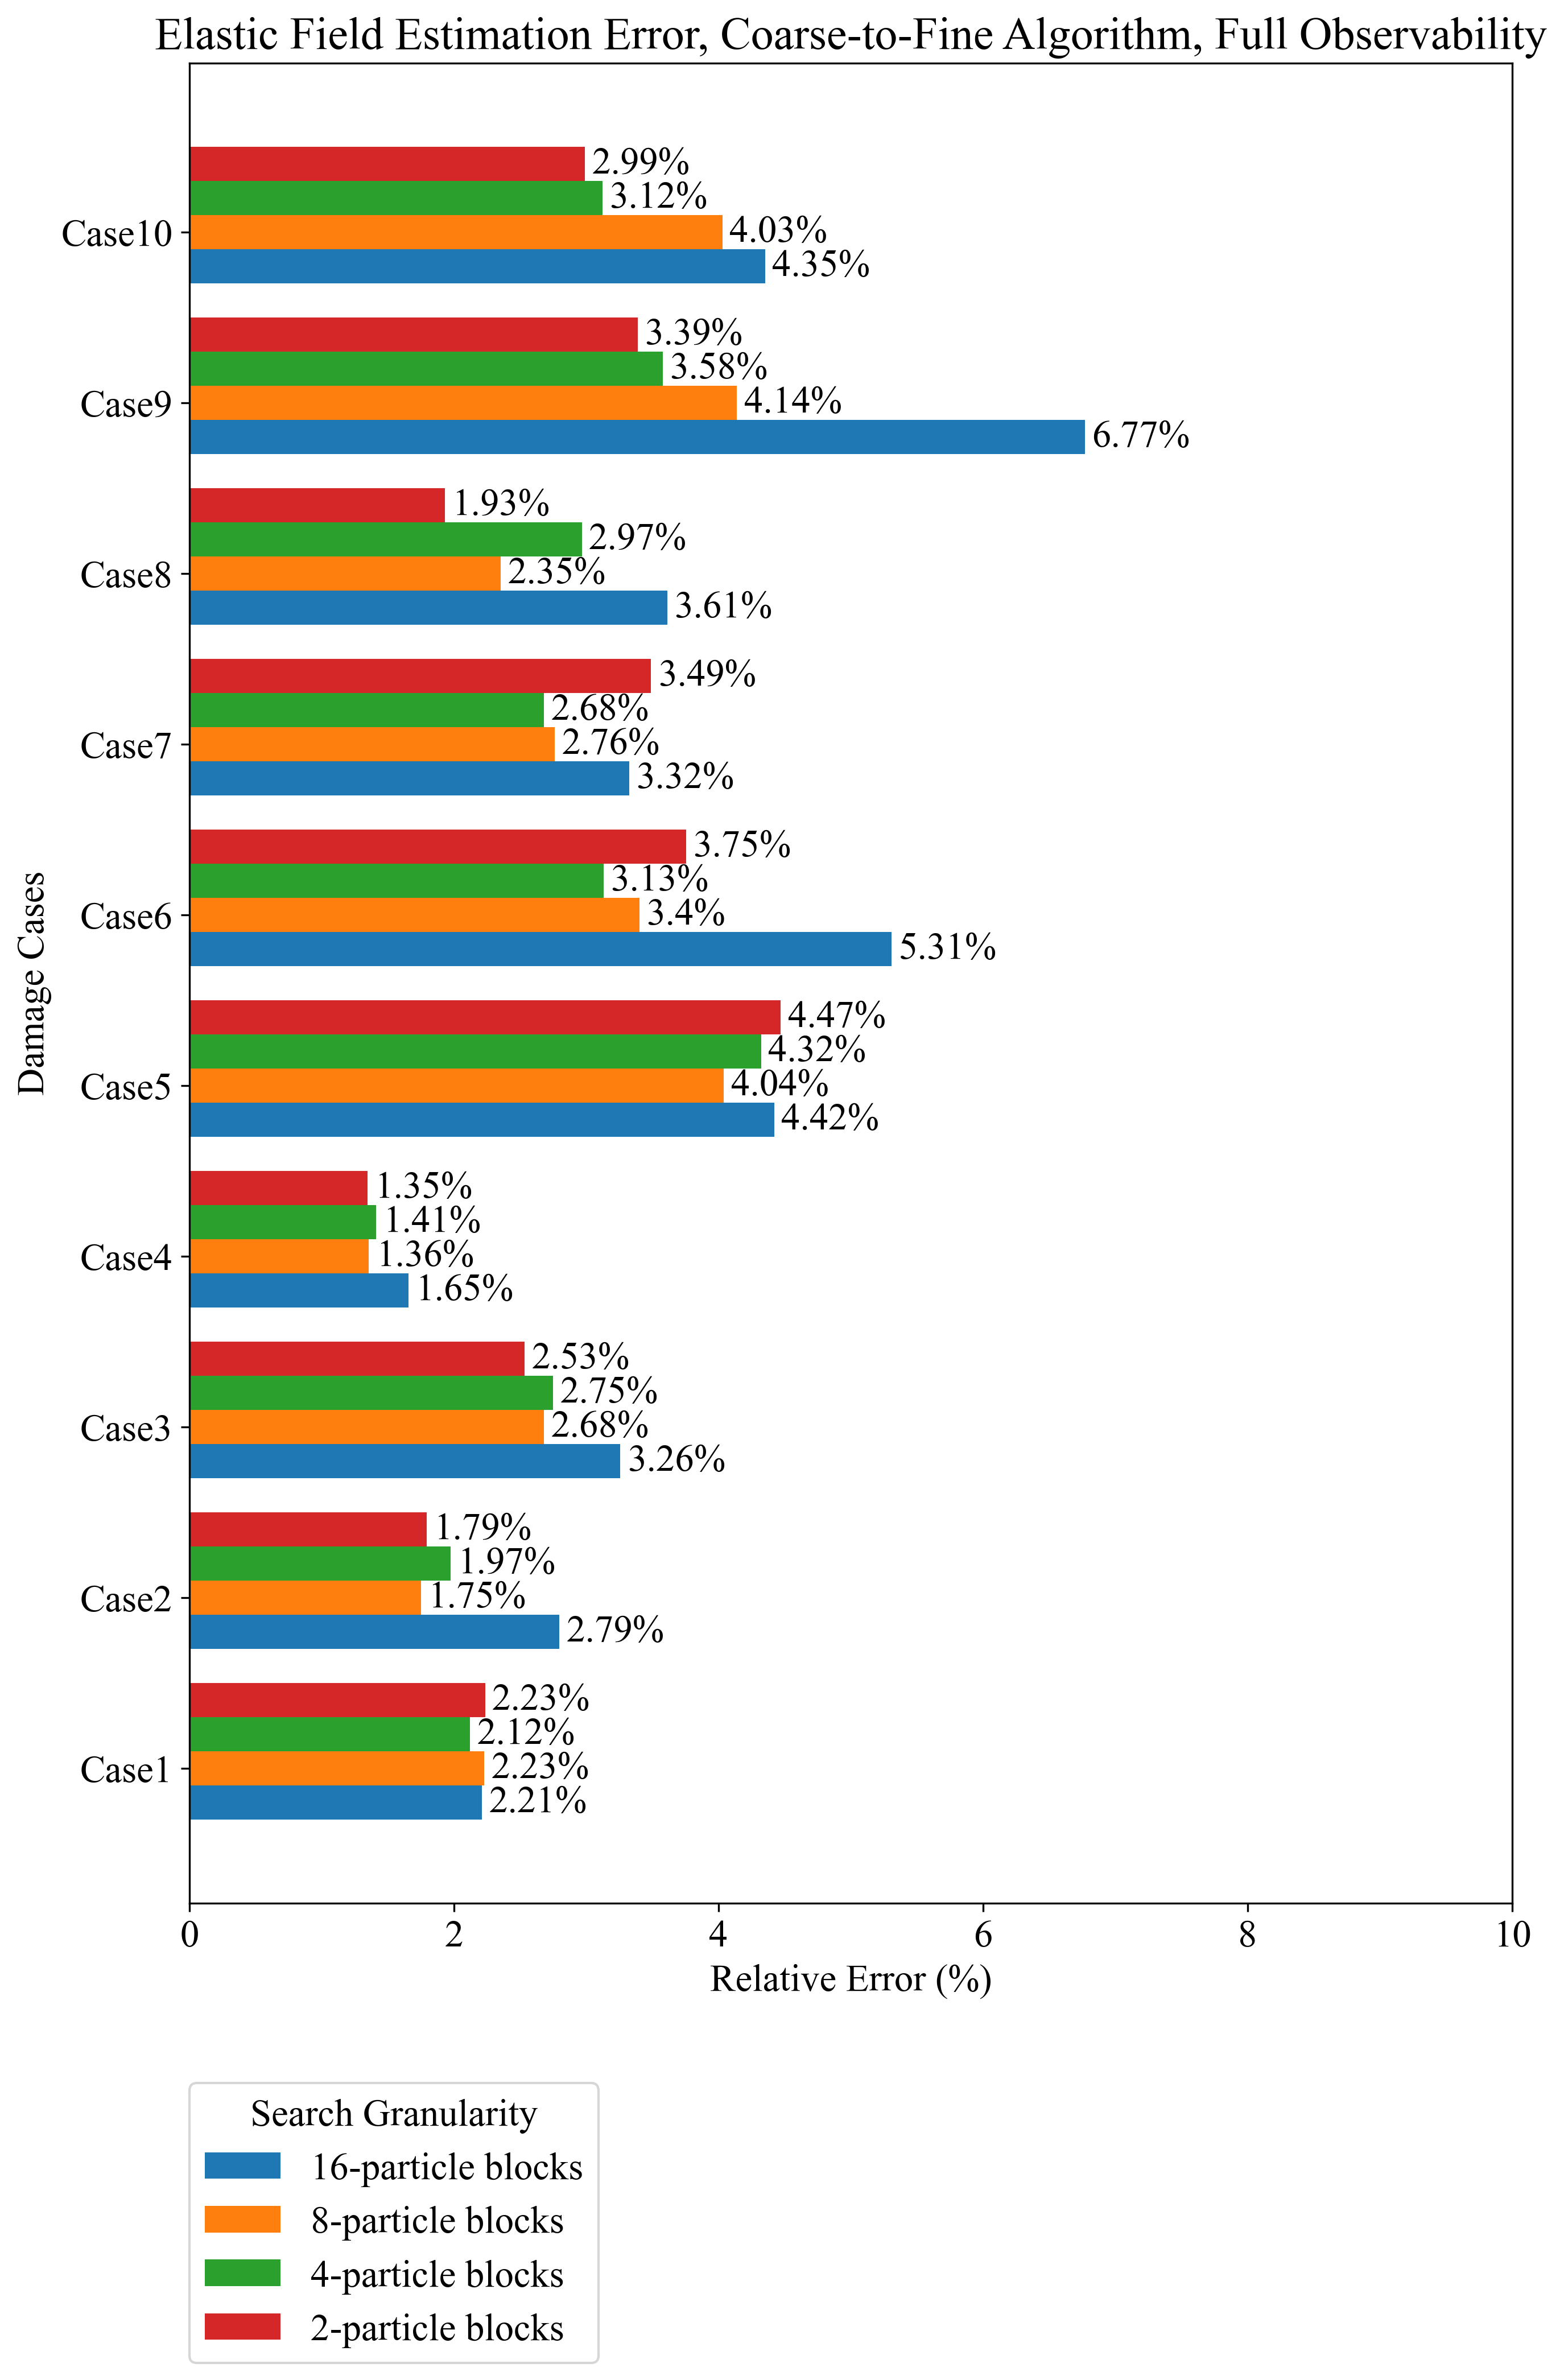

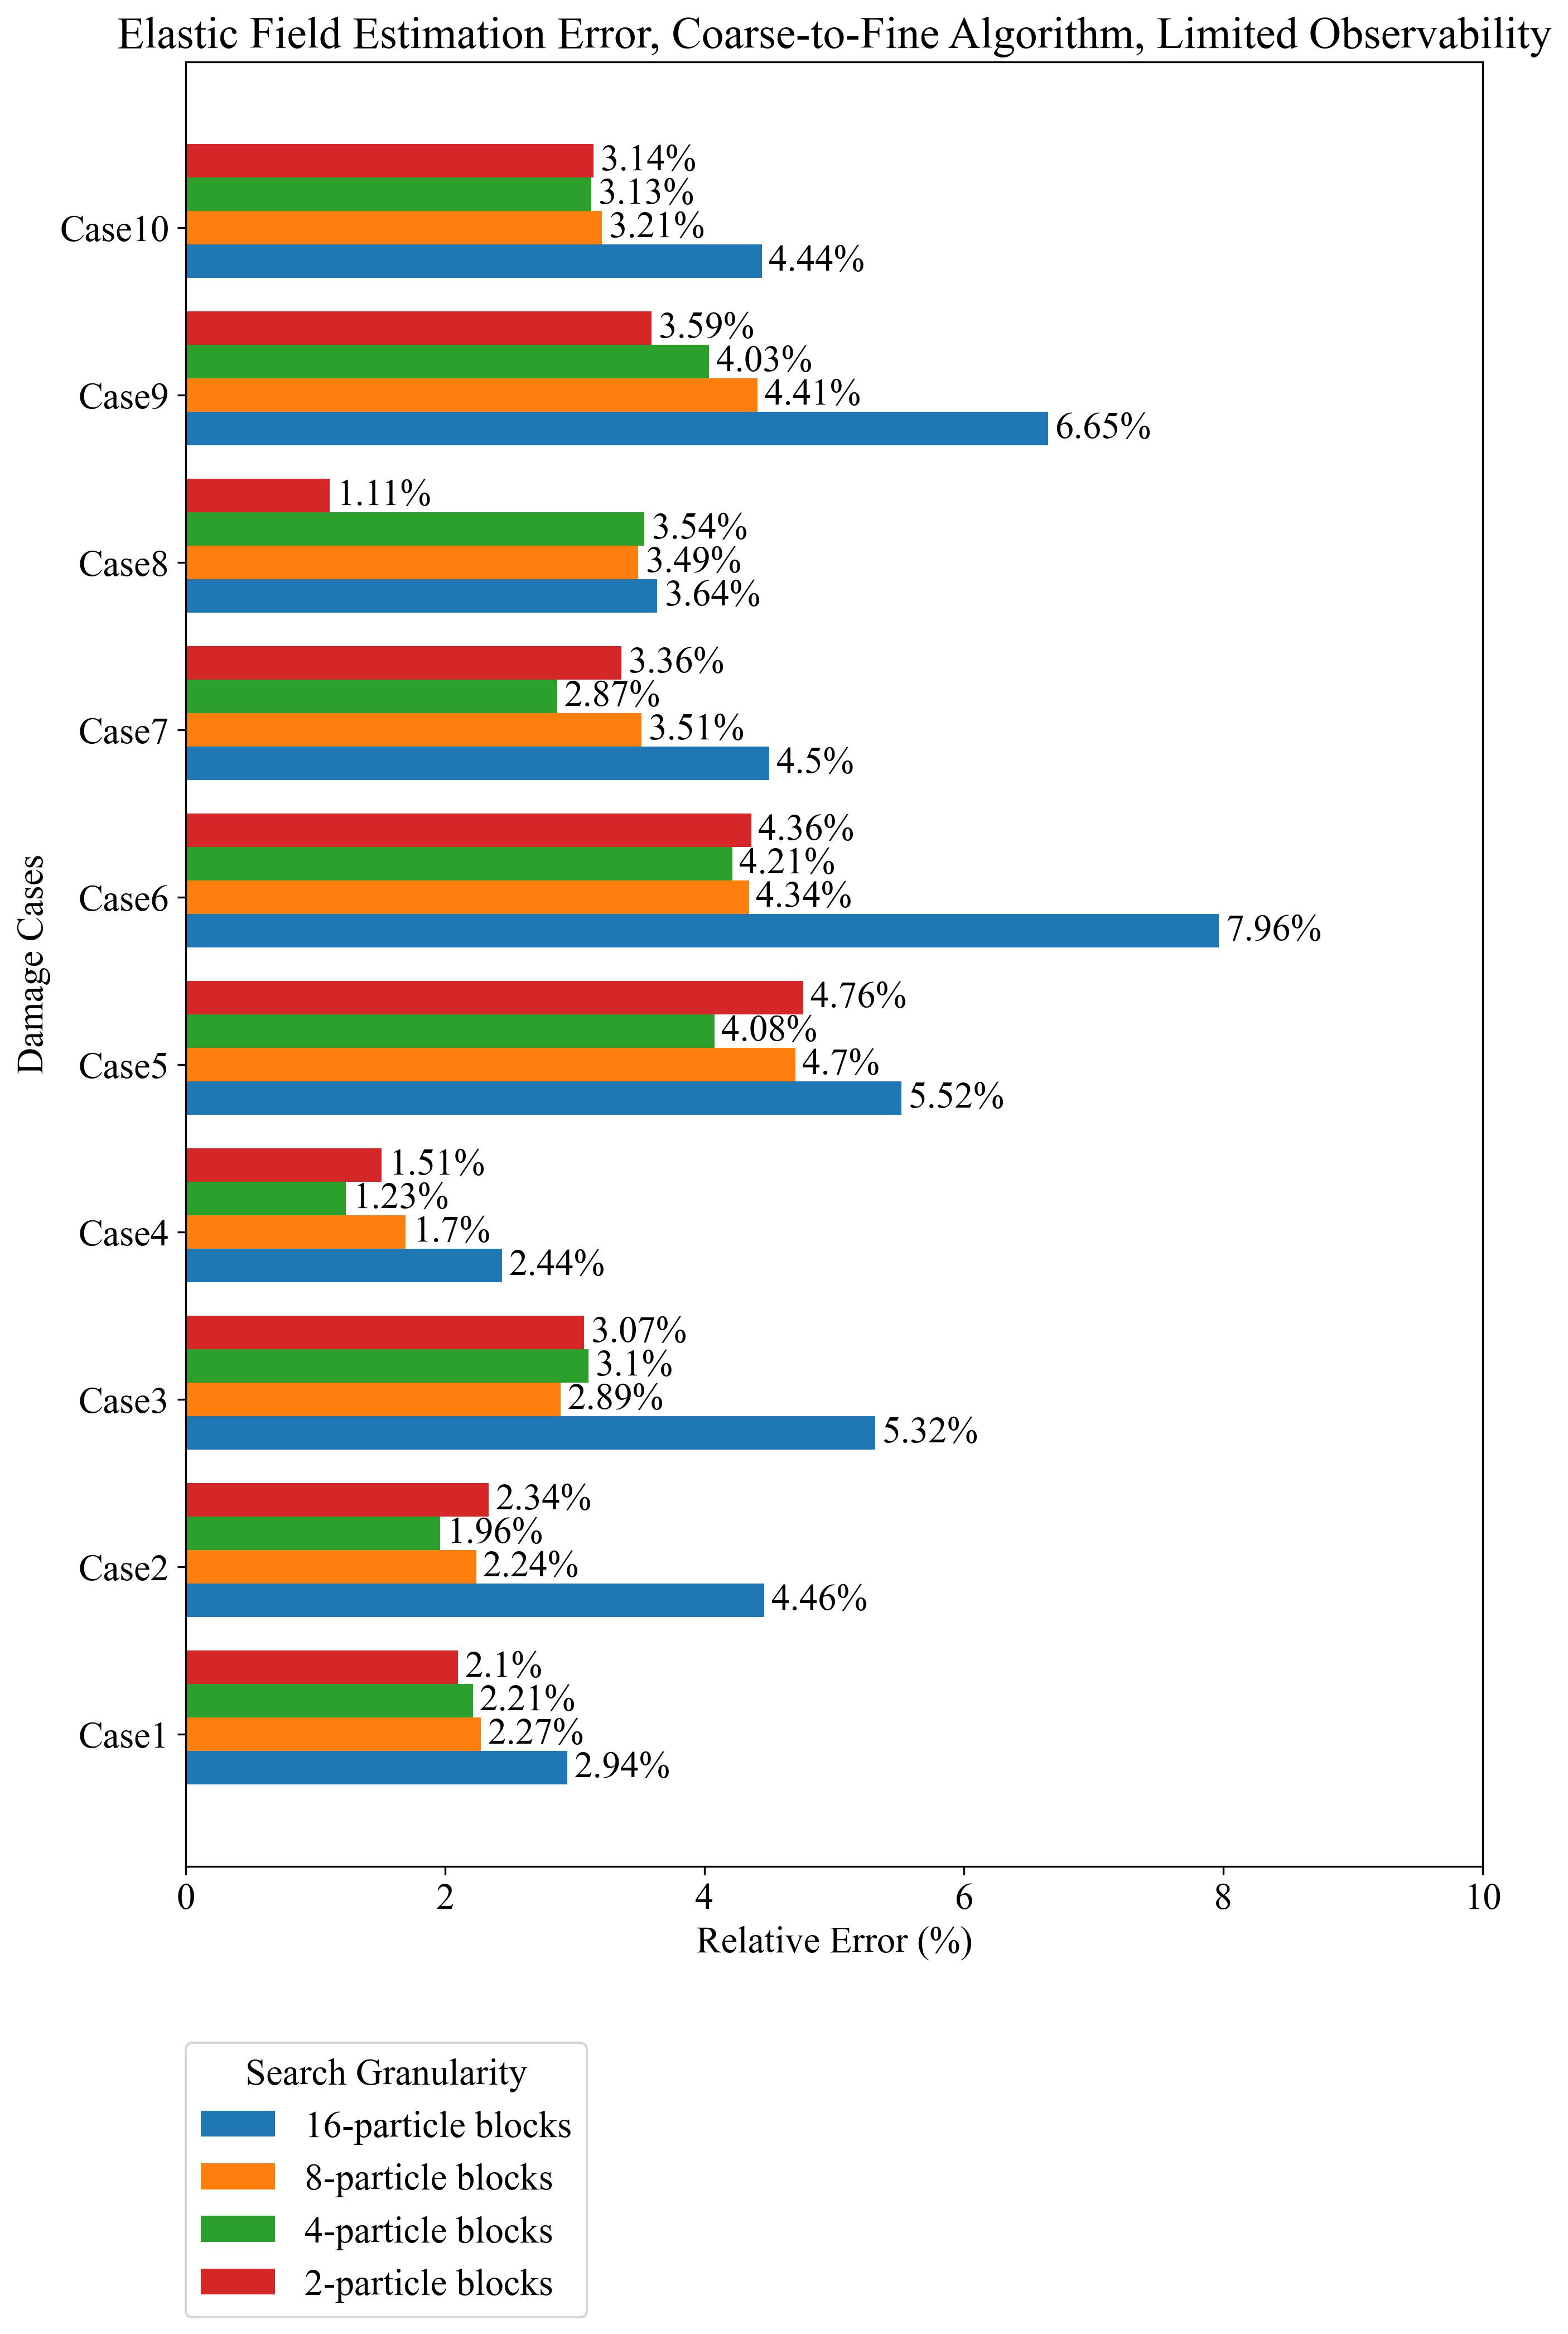

In [76]:
def err_calc(case_i, obs, level, it):
    with open(f"r_c_{cases[case_i]}_{obs}_{int(level*10)}.json") as json_file:
        result = json.load(json_file)['results'][it]
    E_true = E_trues[case_i].flatten()
    error = np.mean(np.abs(np.divide((result - E_true), E_true)))
    return error

E_trues = [E_d, E_g, E_h, E_v, E_d_m, E_g_m, E_v_m, E_gt, E_gt_m, E_ht]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
obs_choices = ["full", "sensor"]
levels = [0.5]
its = [0,1,2,3]



dict_its = {0:"16-particle blocks", 1:"8-particle blocks", 2:"4-particle blocks", 3:"2-particle blocks"}
dict_cases = dict(zip(cases, f"case {range(1,len(cases)+1)}"))
dict_obs = dict(zip(obs_choices, ["Full Observability", 'Limited Observability']))

for obs in obs_choices:
    keys = []
    values = []
    for it in its:
        for level in levels:
            keys.append(f"{dict_its[it]}") # {dict_obs[obs]}, {level} threshold")
            values.append([err_calc(case_i, obs, level, it) for case_i in range(len(cases))])
    species = [f"Case{i+1}" for i in range(len(cases))]
    penguin_means = dict(zip(keys, values))

    x = np.arange(len(species))*2  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    import matplotlib.pyplot as plt
    import matplotlib
    plt.rcdefaults()
    # matplotlib.rc('text', usetex = True)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['figure.dpi'] = 300
    font = {'size'   : 16}
    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(10,14))
    fmt = '%.2g%%' # Format you want the ticks, e.g. '40%'
    # xticks = mtick.FormatStrFormatter(fmt)
    # ax.xaxis.set_major_formatter(xticks)

    def gray(level):
        return (level, level, level)

    for j, (attribute, measurement) in enumerate(penguin_means.items()):
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)*100, width, label=attribute)
        ax.bar_label(rects, padding=3, fmt='%.3g%%')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Relative Error (%)')
    ax.set_title(f'Elastic Field Estimation Error, Coarse-to-Fine Algorithm, {dict_obs[obs]}')
    ax.set_yticks(x + width, species)
    ax.legend(loc=(0,-0.25), title="Search Granularity")
    ax.set_xlim(0, 10)
    ax.set_ylabel('Damage Cases')
    plt.show()

In [ ]:


import matplotlib.pyplot as plt

def err_calc(x_block, y_block, obs):
    name = f"r_c_{x_block}_{y_block}_{obs}.json"
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]        
    
    n_blocks_x = x_block
    n_blocks_y = y_block

    n_blocks = n_blocks_y * n_blocks_x
    block_nx = int(Nx / n_blocks_x)
    block_ny = int(Ny / n_blocks_y)
    E = np.zeros(n_particles)
    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]

    E_true_reshape = einops.rearrange(E_true, "(y x) -> x y", y=Ny)
    E_reshape = einops.rearrange(E, "(y x) -> x y", y=Ny)
    error = np.abs(np.divide((E_reshape - E_true_reshape), E_true_reshape))
    return np.mean(error.flatten())

group_names = [
    '1 Y Row, Full Observability',
    '1 Y Row, Limited Surface Observability',
    '2 Y Rows, Full Observability',
    '2 Y Rows, Limited Surface Observability'
]

x_blocks = [4, 12, 36]
species = ("4", "12", "36")
penguin_means = {
    '1 Y Block, Full': [err_calc(x_block, 1, "full") for x_block in x_blocks],
    '1 Y Block, Limited': [err_calc(x_block, 1, "sensor") for x_block in x_blocks],
    '2 Y Blocks, Full': [err_calc(x_block, 2, "full") for x_block in x_blocks],
    '2 Y Blocks, Limited':[err_calc(x_block, 2, "sensor") for x_block in x_blocks],
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

import matplotlib.pyplot as plt
import matplotlib
plt.rcdefaults()
# matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(12,6))
fmt = '%.2g%%' # Format you want the ticks, e.g. '40%'
# xticks = mtick.FormatStrFormatter(fmt)
# ax.xaxis.set_major_formatter(xticks)

def gray(level):
    return (level, level, level)

for j, (attribute, measurement) in enumerate(penguin_means.items()):
    offset = width * multiplier
    rects = ax.barh(x + offset, np.array(measurement)*100, width, label=attribute, color=gray(j*0.25))
    ax.bar_label(rects, padding=3, fmt='%.3g%%')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Relative Error (%)')
ax.set_title('Elastic Field Estimation Error, Varying Discretization and Observability')
ax.set_yticks(x + width, species)
ax.legend(loc=(1.04,0), title="Number of Y Blocks, Observability")
ax.set_xlim(0, 10)
ax.set_ylabel('Blocks in X Direction')
plt.show()

[Taichi] Starting on arch=cuda


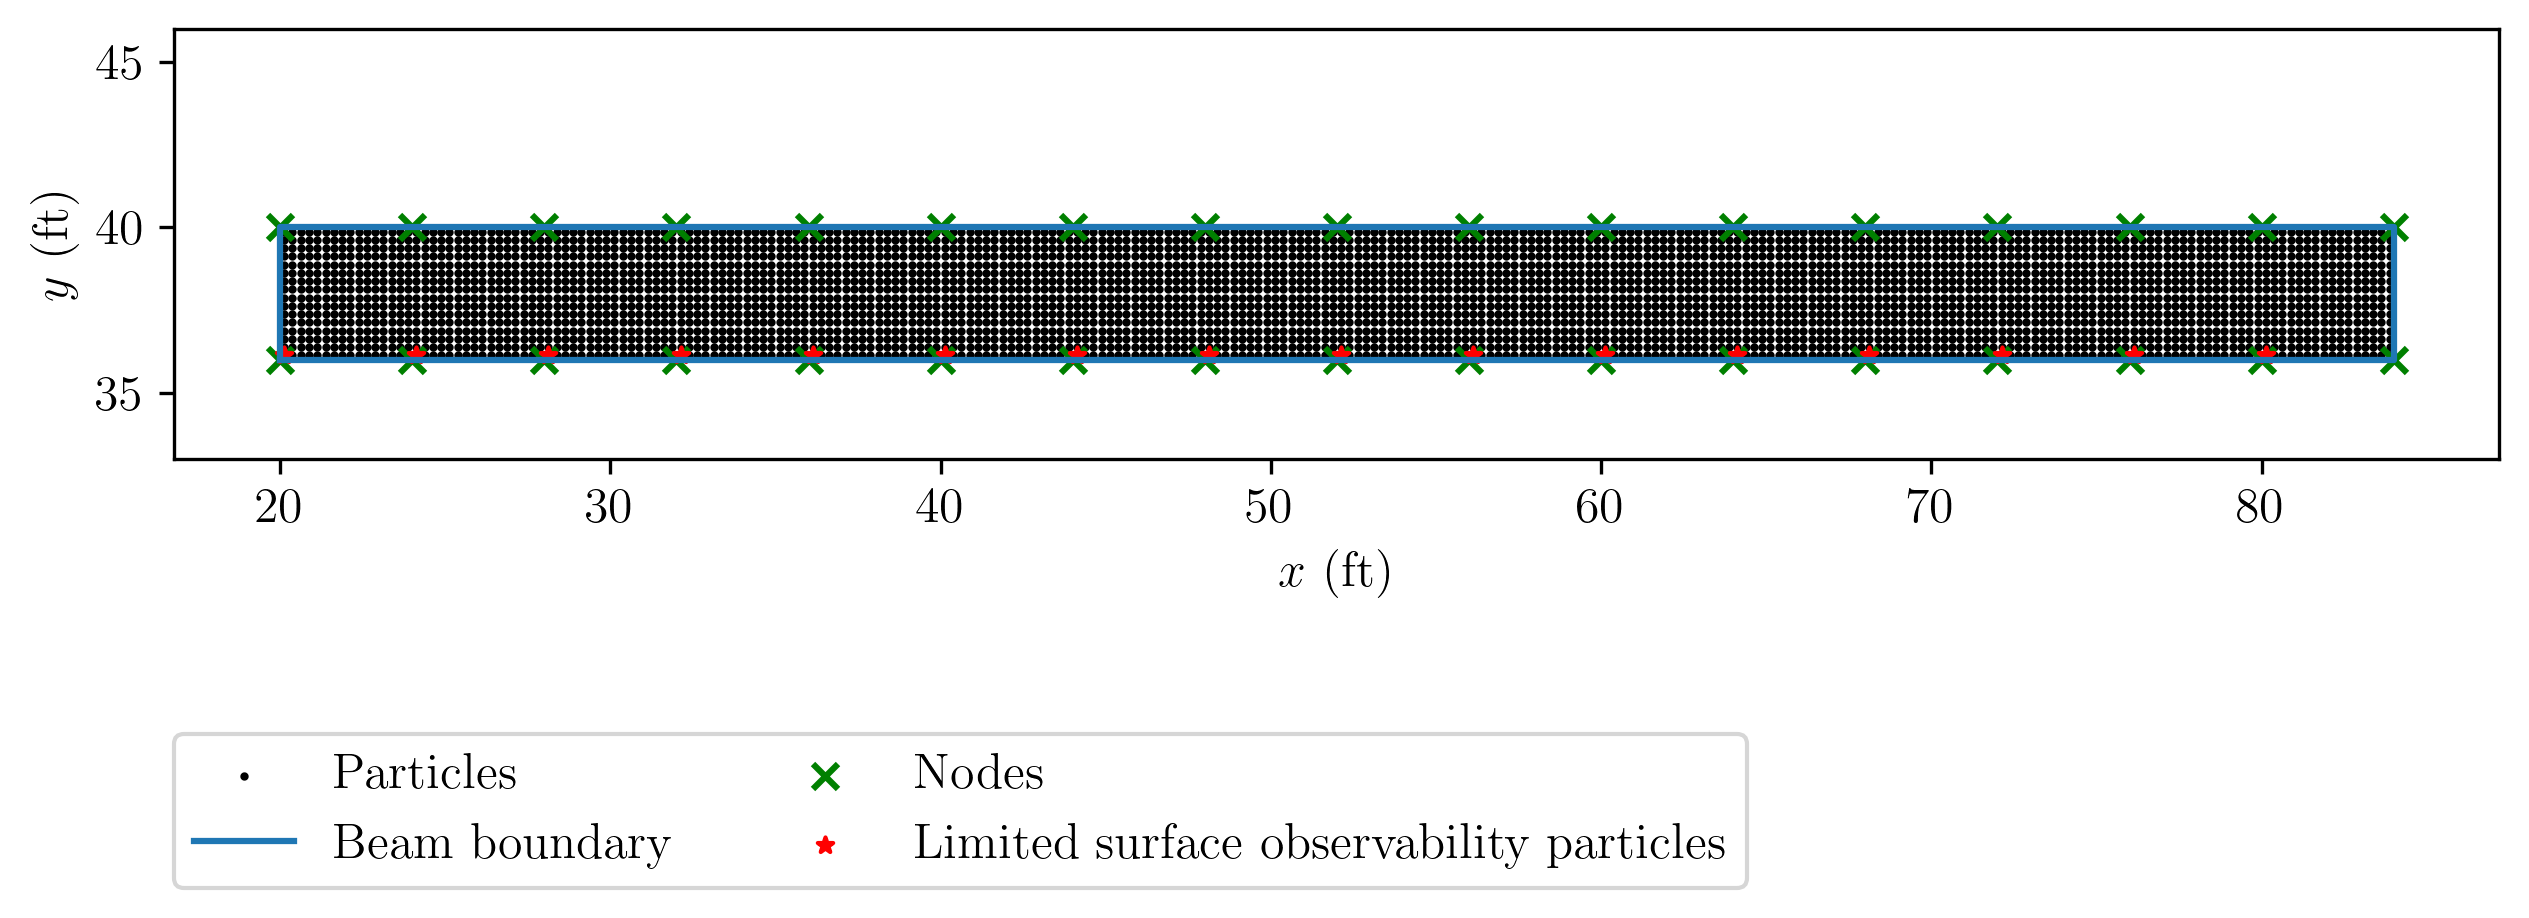

(4096, 2)

In [32]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)
Nx = 256
Ny = 16
n_particles = Nx*Ny
size=100*12
x = ti.Vector.field(2,
                    dtype=real,
                    shape=(n_particles),
                    needs_grad=True)
x_p, y_p = np.zeros(n_particles), np.zeros(n_particles)
x_n, y_n = np.meshgrid(np.arange(17)*4+20, np.arange(2)*4+36)
for i in range(Nx):
    for j in range(Ny):
        x[j * Nx + i] = [
            ((i)/(Nx) * 0.64 + 0.2 + 0.64 / Nx * 0.5) * size/12, 
            ((j)/(Ny) * 0.04 + 0.36 + 0.04 / Ny * 0.5) * size/12]
        x_p[j * Nx + i] = ((i)/(Nx) * 0.64 + 0.2 + 0.64 / Nx * 0.5) * size/12
        y_p[j * Nx + i] = ((j)/(Ny) * 0.04 + 0.36 + 0.04 / Ny * 0.5) * size/12
n_particles = Nx * Ny

x_1, y_1 = np.array([]), np.array([])
x_2, y_2 = np.array([]), np.array([])
x_3, y_3 = np.array([]), np.array([])
x_4, y_4 = np.array([]), np.array([])

for i in range(n_particles):
    col = i % Nx
    if col < 45:
        x_1 = np.append(x_1, x_p[i])
        y_1 = np.append(y_1, y_p[i])
    elif col >= 45 and col < 90:
        x_2 = np.append(x_2, x_p[i])
        y_2 = np.append(y_2, y_p[i])
    elif col >= 90 and col < 135:
        x_3 = np.append(x_3, x_p[i])
        y_3 = np.append(y_3, y_p[i])
    else:
        x_4 = np.append(x_4, x_p[i])
        y_4 = np.append(y_4, y_p[i])

x = x.to_numpy()

matplotlib.rc('text', usetex = True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
font = {'size'   : 20}
def gray(level):
    return (level, level, level)

plt.figure(figsize=(10,3))
s=4
plt.scatter(x_1, y_1, color=gray(0), marker = '.',s=s, label='Particles')
plt.scatter(x_2, y_2, color=gray(0), marker = '.', s=s)
plt.scatter(x_3, y_3, color=gray(0), marker = '.', s=s)
plt.scatter(x_4, y_4, color=gray(0), marker = '.', s=s)
plt.plot(np.array([0.2, 0.84, 0.84, 0.2, 0.2])*size/12, np.array([0.36, 0.36, 0.4, 0.4, 0.36])*size/12, label='Beam boundary')
plt.scatter(x_n, y_n, color='g', marker='x', label='Nodes')
# plt.scatter(x[:,0], x[:,1], marker='.', label='800 (Full Observability)')
# plt.scatter(x[:180,0], x[:180,1], marker='D', s=3, color='blue', label='Surface observability particles')
plt.scatter(x[:256,0][::16], x[:256,1][::16], marker='*', color='r', s=15, label='Limited surface observability particles')

plt.legend(loc=(0, -1), ncol=2)
# plt.title('Material Points Used Per Observability Case')
plt.xlabel('$x$ (ft)')
plt.ylabel('$y$ (ft)')
plt.ylim((33,46))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig('slender_beam.png', dpi=300, bbox_inches = "tight")
plt.show()

x.shape

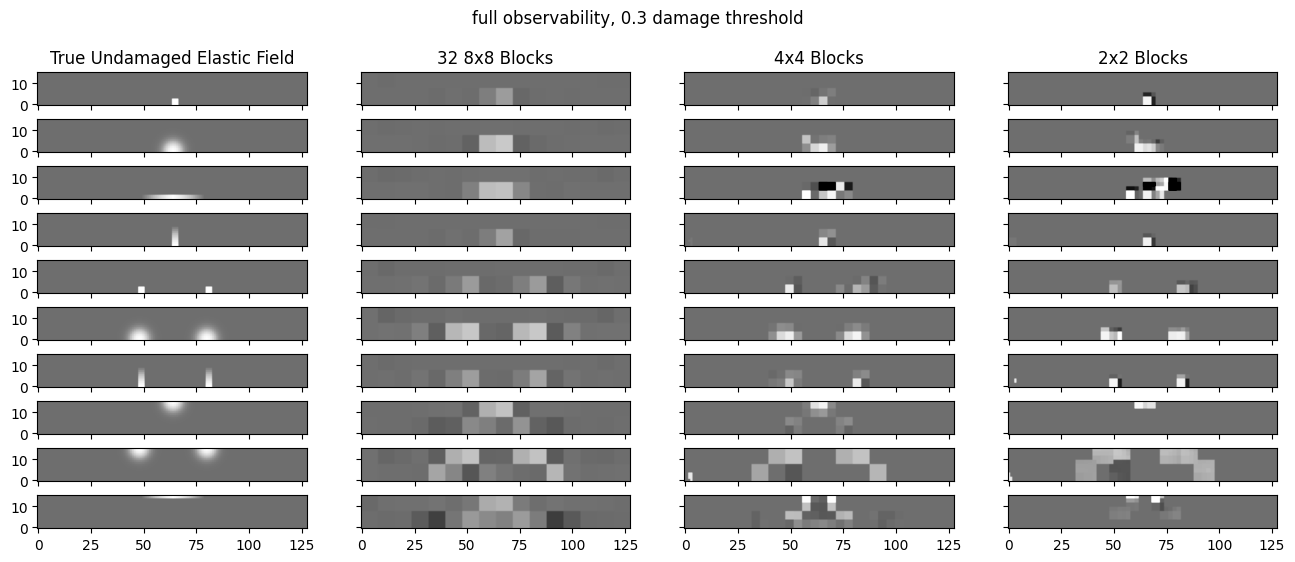

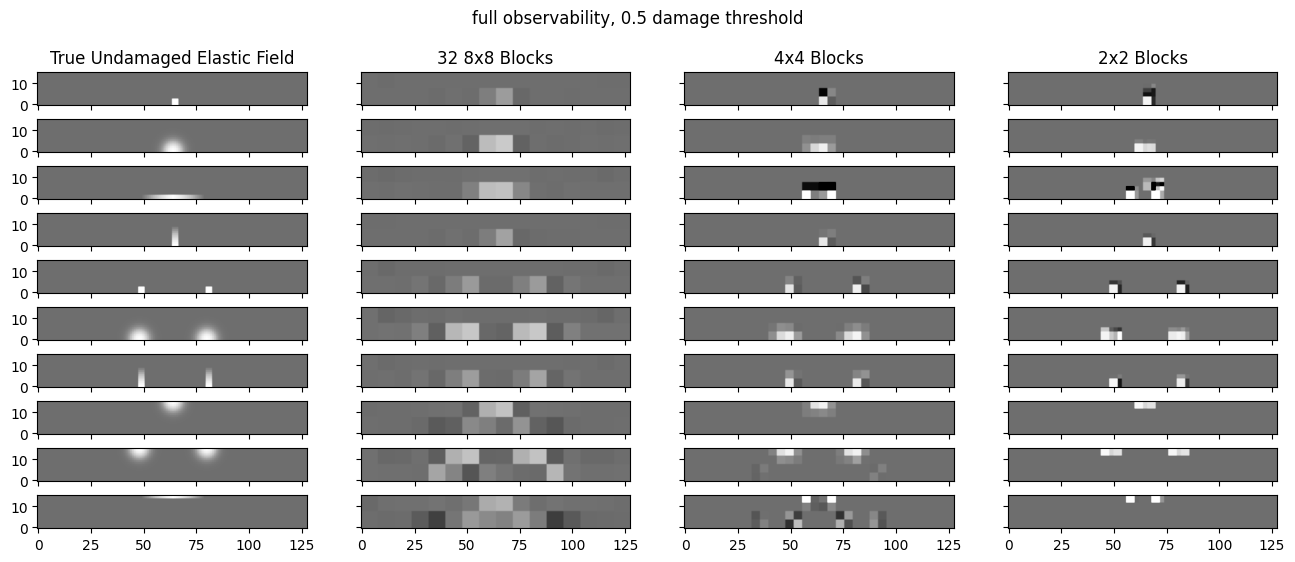

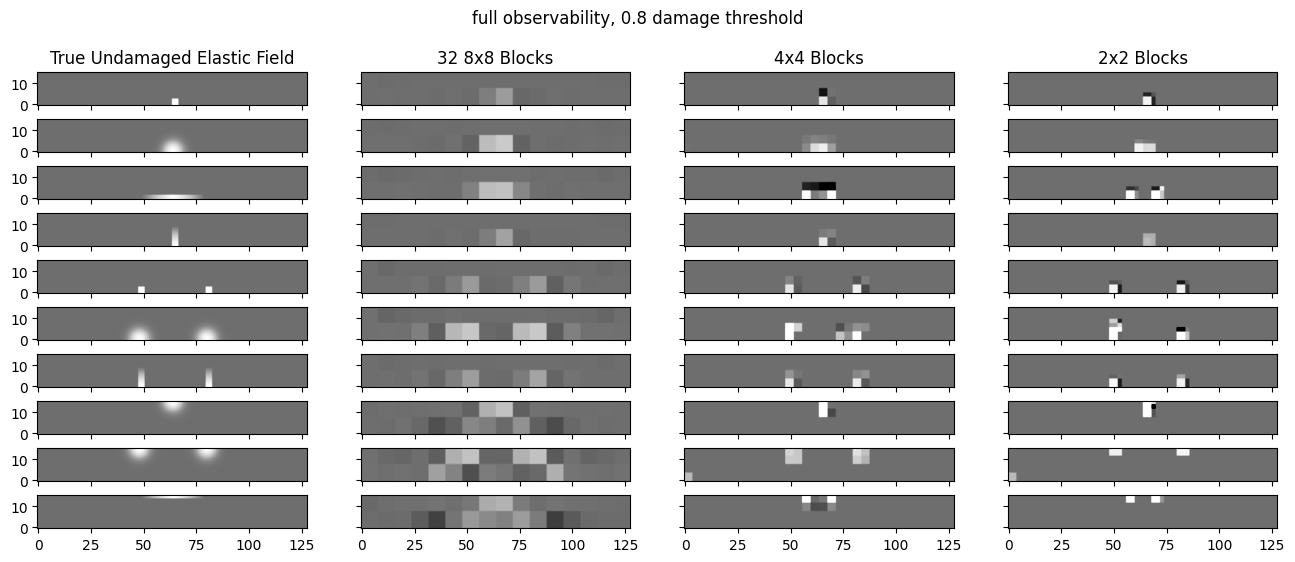

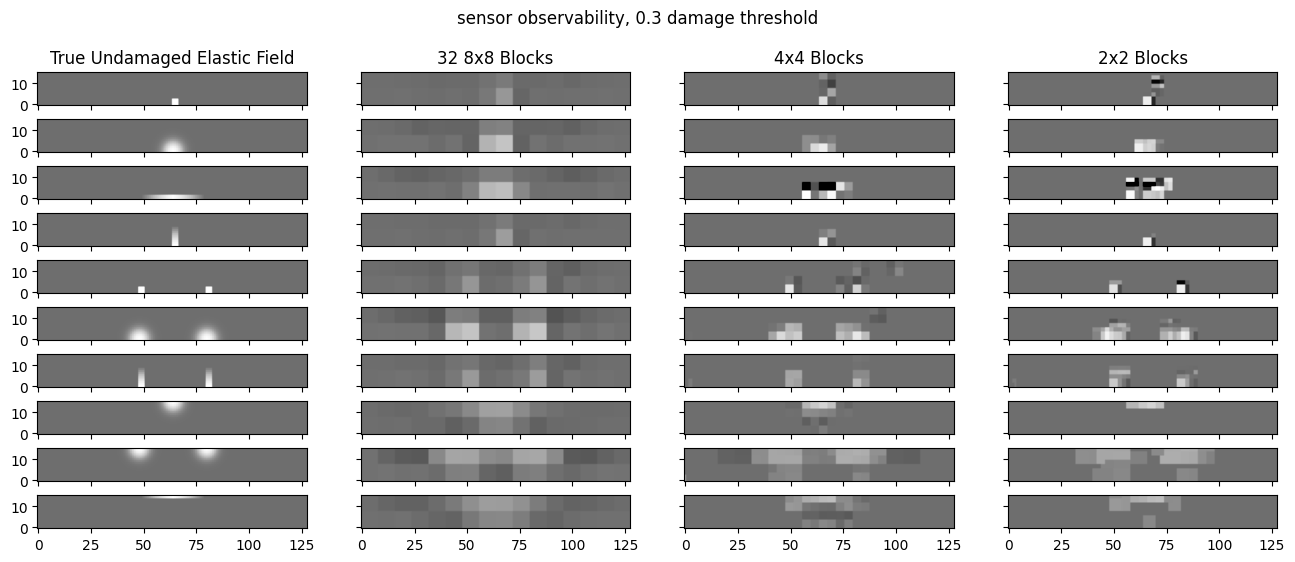

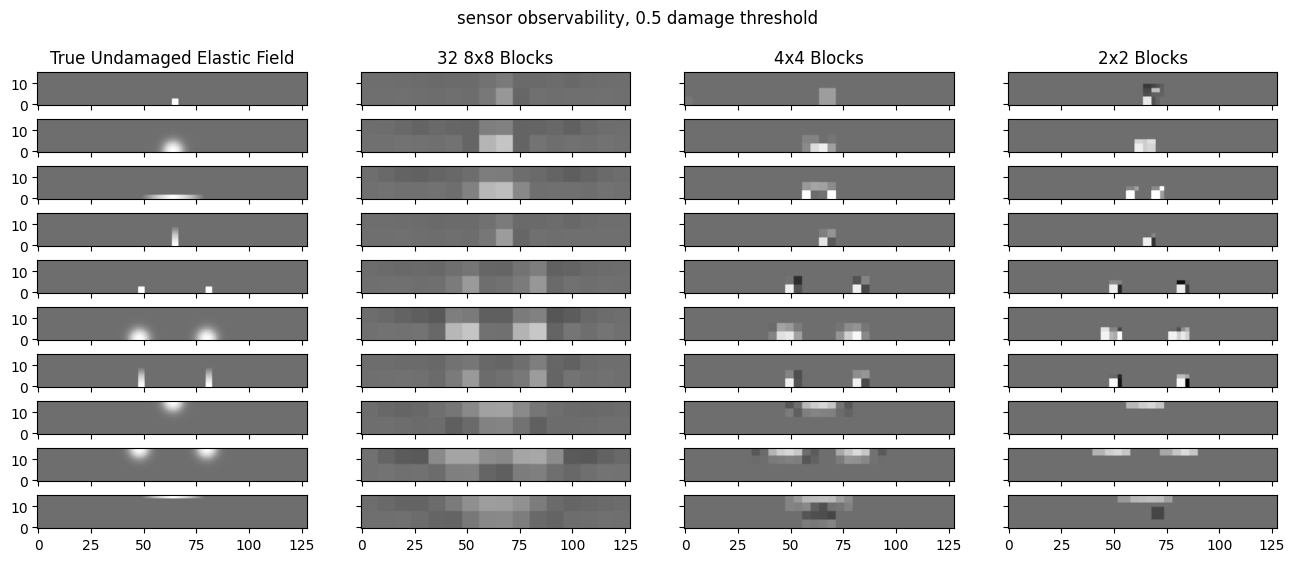

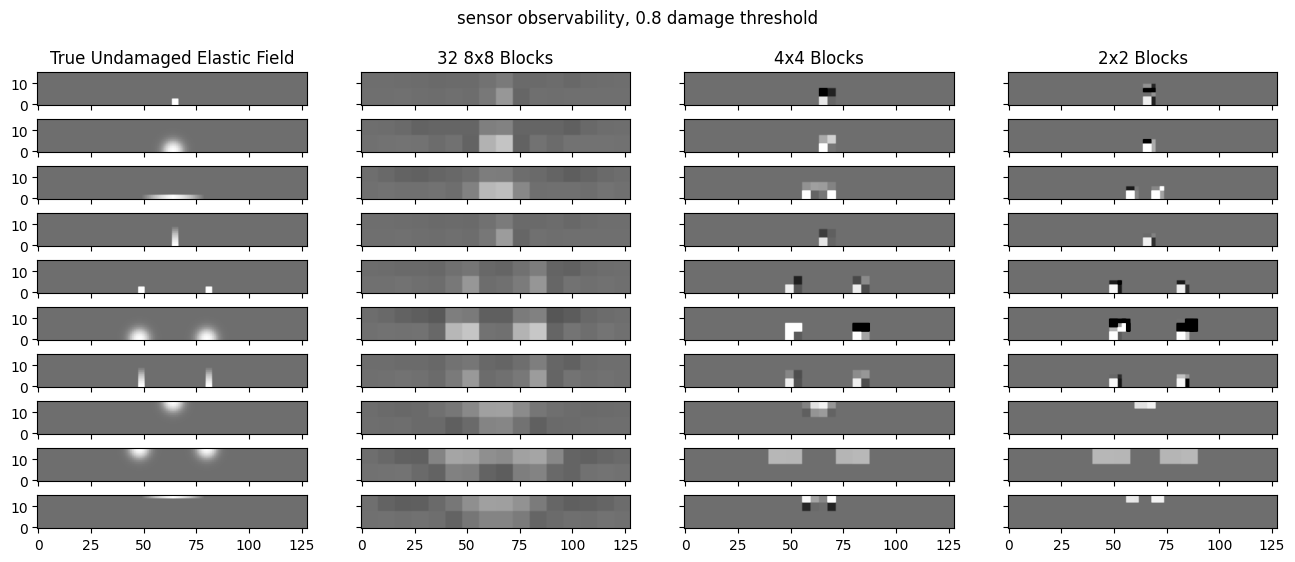

In [ ]:



# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

obs_choices = ["full", "sensor"]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
deviation_threshold_list = [0.3, 0.5, 0.8]

obs = 'full'
threshold = 0.5

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 128
Ny = 16
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for obs in obs_choices:
    for threshold in deviation_threshold_list:
        fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


        fig.suptitle(f'{obs} observability, {threshold} damage threshold')

        axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[0, 0].set_title('True Undamaged Elastic Field')
        axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        # for i in range(10):
        #     axs[i, 0].set_ylabel(str(i))

        for k, case in enumerate(cases):
            filename = [
                f"r_{case}_{obs}_{int(threshold*10)}.json",
            ]
            for z in range(3):
                with open(filename[0]) as json_file:
                    result = json.load(json_file)['results'][z]   
                E = np.zeros(n_particles)
                for i in range(Nx):
                    for j in range(Ny):
                        E[j*Nx+i] = result[i + j * Nx]
                E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
                
                axs[k, z + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

        axs[0, 1].set_title('32 8x8 Blocks')
        axs[0, 2].set_title('4x4 Blocks')
        axs[0, 3].set_title('2x2 Blocks')
        # axs[0, 4].set_title('Individual Particles')
        plt.show()
